<a href="https://colab.research.google.com/github/maisagerk/PerfilParticipantes/blob/main/Perfil_de_Aloca%C3%A7%C3%A3o_dos_Participantes_vfinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [254]:
# Importação de bibliotecas
import numpy as np
from numpy import unique
from numpy import where
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from sklearn.metrics import davies_bouldin_score
from yellowbrick.cluster import KElbowVisualizer
pd.set_option('max_rows', 99999)

###Importação dos Dados

#### Grupo de Participantes

In [7]:
# Importando o arquivo grupo
grupo = pd.read_csv('grupo.csv', delimiter= ";",  usecols=[0,1,2,3,4,5], engine='python', encoding='latin-1')

# Converte o formato das colunas DtNascimento e DtIncricaoPlano para datetime
grupo['DtNascimento']= pd.to_datetime(grupo['DtNascimento'],dayfirst= True )
grupo['DtIncricaoPlano']= pd.to_datetime(grupo['DtIncricaoPlano'],dayfirst= True )

# Visualização dos dados
grupo.head()

,ID,DtNascimento,Sexo,Escolaridade,FaixaSalarial,DtIncricaoPlano
0,1,1976-01-30,M,Superior Completo,L2,2012-05-16
1,2,1978-10-30,M,Superior Completo,L1,2012-02-03
2,3,1975-11-13,F,Superior Completo,L1,2011-04-12
3,4,1955-06-02,M,Superior Completo,L1,1984-06-25
4,5,1971-03-17,F,Superior Completo,L1,2006-03-07


###### Tratamento dos Dados

In [8]:
# Existem valores nulos (por coluna)? 
print(grupo.isnull().any())

ID                 False
DtNascimento       False
Sexo               False
Escolaridade       False
FaixaSalarial      False
DtIncricaoPlano    False
dtype: bool


In [9]:
 print(grupo.shape[0])

6044


In [10]:
# Distribuição de Escolaridade
grupo['Escolaridade'].value_counts(normalize=True)

Superior Completo      0.635341
2o. Grau Completo      0.217075
Pos-Graduacao          0.095963
Superior Incompleto    0.036400
Mestrado               0.007280
2o. Grau Incompleto    0.006618
1o. Grau Completo      0.001324
Name: Escolaridade, dtype: float64

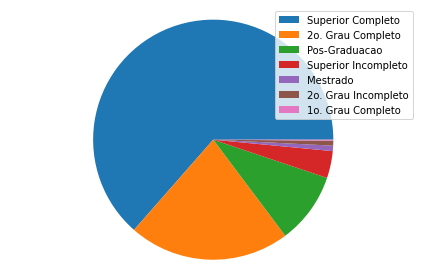

In [11]:
# Gráfico de Distribuição de Escolaridade
plt.pie(grupo.Escolaridade.value_counts());
plt.legend(labels=grupo['Escolaridade'].value_counts().index.tolist());
plt.axis('equal');
plt.tight_layout();

In [12]:
# Analisando a distribuição por Faixa Salarial dos Participantes
grupo.FaixaSalarial.value_counts()

L2    4260
L3    1282
L1     502
Name: FaixaSalarial, dtype: int64

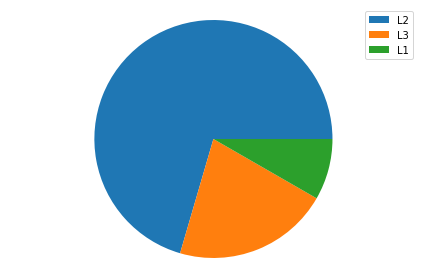

In [13]:
# Gráfico de distribuição por Faixa Salarial 
plt.pie(grupo.FaixaSalarial.value_counts());
plt.legend(labels=grupo['FaixaSalarial'].value_counts().index.tolist());
plt.axis('equal');
plt.tight_layout();

In [14]:
# Analisando a distribuição por Sexo dos Participantes
grupo.Sexo.value_counts(normalize=True)

M    0.731635
F    0.268365
Name: Sexo, dtype: float64

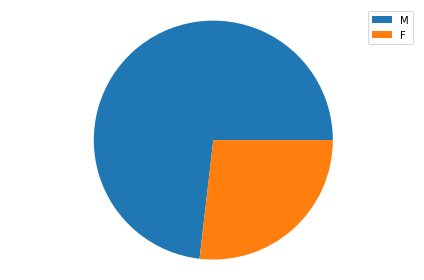

In [15]:
# Gráfico de distribuição por Sexo dos Participantes
plt.pie(grupo.Sexo.value_counts());
plt.legend(labels=grupo['Sexo'].value_counts().index.tolist());
plt.axis('equal');
plt.tight_layout();

###### Criando tabela Grupo com colunas Dummy

In [224]:
grupo_clean = grupo [['ID', 'Sexo','Escolaridade','FaixaSalarial']]
grupo_clean.head(5)

,ID,Sexo,Escolaridade,FaixaSalarial
0,1,M,Superior Completo,L2
1,2,M,Superior Completo,L1
2,3,F,Superior Completo,L1
3,4,M,Superior Completo,L1
4,5,F,Superior Completo,L1


In [225]:
# Dados de Sexo = M
grupo_M = grupo_clean[grupo.Sexo == 'M']

lista_M = [1]*len(grupo_M)
lista_F = [0]*len(grupo_M)

grupo_M['M'] = lista_M
grupo_M['F'] = lista_F

grupo_M = grupo_M [['ID', 'M', 'F']]

# Criando colunas M e F para substituir coluna Sexo por variáveis Dummy
grupo_Dummies_MF = pd.merge(grupo_clean,grupo_M, how='left', on='ID')

grupo_Dummies_MF["F"].fillna(value=1, inplace=True)
grupo_Dummies_MF["M"].fillna(value=0, inplace=True)

grupo_Dummies_MF = grupo_Dummies_MF.drop(columns=['Sexo'])
grupo_Dummies_MF.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ID,Escolaridade,FaixaSalarial,M,F
0,1,Superior Completo,L2,1.0,0.0
1,2,Superior Completo,L1,1.0,0.0
2,3,Superior Completo,L1,0.0,1.0
3,4,Superior Completo,L1,1.0,0.0
4,5,Superior Completo,L1,0.0,1.0


In [17]:
print(grupo_Dummies_MF.isnull().any())

ID                 False
DtNascimento       False
Escolaridade       False
FaixaSalarial      False
DtIncricaoPlano    False
M                  False
F                  False
dtype: bool


In [226]:
# Dados de Escolaridade = Superior Completo
grupo_SupCompl = grupo_clean[grupo_clean.Escolaridade == 'Superior Completo']

lista_SupCompl = [1]*len(grupo_SupCompl);

grupo_SupCompl['SuperiorCompleto'] = lista_SupCompl;

grupo_SupCompl = grupo_SupCompl [['ID', 'SuperiorCompleto']]


# Criando coluna SuperiorCompleto 
grupo_Dummies_SupCompl = pd.merge(grupo_Dummies_MF,grupo_SupCompl, how='left', on='ID')

grupo_Dummies_SupCompl["SuperiorCompleto"].fillna(value=0, inplace=True)

grupo_Dummies_SupCompl.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ID,Escolaridade,FaixaSalarial,M,F,SuperiorCompleto
0,1,Superior Completo,L2,1.0,0.0,1.0
1,2,Superior Completo,L1,1.0,0.0,1.0
2,3,Superior Completo,L1,0.0,1.0,1.0
3,4,Superior Completo,L1,1.0,0.0,1.0
4,5,Superior Completo,L1,0.0,1.0,1.0


In [227]:
# Dados de Escolaridade = 2o. Grau Completo
grupo_SegGrauCompl = grupo_clean[grupo_clean.Escolaridade == '2o. Grau Completo']

lista_SegGrauCompl = [1]*len(grupo_SegGrauCompl)

grupo_SegGrauCompl['SegGrauCompleto'] = lista_SegGrauCompl

grupo_SegGrauCompl = grupo_SegGrauCompl [['ID', 'SegGrauCompleto']]


# Criando coluna SuperiorCompleto 
grupo_Dummies_SegGrauCompl = pd.merge(grupo_Dummies_SupCompl,grupo_SegGrauCompl, how='left', on='ID')

grupo_Dummies_SegGrauCompl["SegGrauCompleto"].fillna(value=0, inplace=True)

grupo_Dummies_SegGrauCompl.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ID,Escolaridade,FaixaSalarial,M,F,SuperiorCompleto,SegGrauCompleto
0,1,Superior Completo,L2,1.0,0.0,1.0,0.0
1,2,Superior Completo,L1,1.0,0.0,1.0,0.0
2,3,Superior Completo,L1,0.0,1.0,1.0,0.0
3,4,Superior Completo,L1,1.0,0.0,1.0,0.0
4,5,Superior Completo,L1,0.0,1.0,1.0,0.0


In [228]:
# Dados de Escolaridade = Pos-Graduacao
grupo_PosGrad = grupo_clean[grupo_clean.Escolaridade == 'Pos-Graduacao']

lista_PosGrad = [1]*len(grupo_PosGrad)

grupo_PosGrad['PosGraduacao'] = lista_PosGrad

grupo_PosGrad = grupo_PosGrad [['ID', 'PosGraduacao']]


# Criando coluna SuperiorCompleto 
grupo_Dummies_PosGrad = pd.merge(grupo_Dummies_SegGrauCompl,grupo_PosGrad, how='left', on='ID')

grupo_Dummies_PosGrad["PosGraduacao"].fillna(value=0, inplace=True)

grupo_Dummies_PosGrad.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ID,Escolaridade,FaixaSalarial,M,F,SuperiorCompleto,SegGrauCompleto,PosGraduacao
0,1,Superior Completo,L2,1.0,0.0,1.0,0.0,0.0
1,2,Superior Completo,L1,1.0,0.0,1.0,0.0,0.0
2,3,Superior Completo,L1,0.0,1.0,1.0,0.0,0.0
3,4,Superior Completo,L1,1.0,0.0,1.0,0.0,0.0
4,5,Superior Completo,L1,0.0,1.0,1.0,0.0,0.0


In [229]:
# Dados de Escolaridade = Superior Incompleto
grupo_SupInc = grupo_clean[grupo_clean.Escolaridade == 'Superior Incompleto']

lista_SupInc = [1]*len(grupo_SupInc)

grupo_SupInc['SuperiorIncompleto'] = lista_SupInc

grupo_SupInc = grupo_SupInc [['ID', 'SuperiorIncompleto']]


# Criando coluna SuperiorCompleto 
grupo_Dummies_SupInc = pd.merge(grupo_Dummies_PosGrad,grupo_SupInc, how='left', on='ID')

grupo_Dummies_SupInc["SuperiorIncompleto"].fillna(value=0, inplace=True)

grupo_Dummies_SupInc.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ID,Escolaridade,FaixaSalarial,M,F,SuperiorCompleto,SegGrauCompleto,PosGraduacao,SuperiorIncompleto
0,1,Superior Completo,L2,1.0,0.0,1.0,0.0,0.0,0.0
1,2,Superior Completo,L1,1.0,0.0,1.0,0.0,0.0,0.0
2,3,Superior Completo,L1,0.0,1.0,1.0,0.0,0.0,0.0
3,4,Superior Completo,L1,1.0,0.0,1.0,0.0,0.0,0.0
4,5,Superior Completo,L1,0.0,1.0,1.0,0.0,0.0,0.0


In [230]:
# Dados de Escolaridade = Mestrado
grupo_Mestrado = grupo_clean[grupo_clean.Escolaridade == 'Mestrado']

lista_Mestrado = [1]*len(grupo_Mestrado)

grupo_Mestrado['Mestrado'] = lista_Mestrado

grupo_Mestrado = grupo_Mestrado [['ID', 'Mestrado']]


# Criando coluna SuperiorCompleto 
grupo_Dummies_Mestrado = pd.merge(grupo_Dummies_SupInc,grupo_Mestrado, how='left', on='ID')

grupo_Dummies_Mestrado["Mestrado"].fillna(value=0, inplace=True)

grupo_Dummies_Mestrado.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ID,Escolaridade,FaixaSalarial,M,F,SuperiorCompleto,SegGrauCompleto,PosGraduacao,SuperiorIncompleto,Mestrado
0,1,Superior Completo,L2,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2,Superior Completo,L1,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3,Superior Completo,L1,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,4,Superior Completo,L1,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,5,Superior Completo,L1,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [231]:
# Dados de Escolaridade = 2o. Grau Incompleto
grupo_SegGrauInc = grupo_clean[grupo_clean.Escolaridade == '2o. Grau Incompleto']

lista_SegGrauInc = [1]*len(grupo_SegGrauInc)

grupo_SegGrauInc['SegGrauIncompleto'] = lista_SegGrauInc

grupo_SegGrauInc = grupo_SegGrauInc [['ID', 'SegGrauIncompleto']]


# Criando coluna SuperiorCompleto 
grupo_Dummies_SegGrauInc = pd.merge(grupo_Dummies_Mestrado,grupo_SegGrauInc, how='left', on='ID')

grupo_Dummies_SegGrauInc["SegGrauIncompleto"].fillna(value=0, inplace=True)

grupo_Dummies_SegGrauInc.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ID,Escolaridade,FaixaSalarial,M,F,SuperiorCompleto,SegGrauCompleto,PosGraduacao,SuperiorIncompleto,Mestrado,SegGrauIncompleto
0,1,Superior Completo,L2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2,Superior Completo,L1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,3,Superior Completo,L1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,4,Superior Completo,L1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,5,Superior Completo,L1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [236]:
# Dados de Escolaridade = 1o. Grau Completo
grupo_PrimGrauComp = grupo_clean[grupo_clean.Escolaridade == '1o. Grau Completo']

lista_PrimGrauComp = [1]*len(grupo_PrimGrauComp)

grupo_PrimGrauComp['PrimGrauCompleto'] = lista_PrimGrauComp

grupo_PrimGrauComp = grupo_PrimGrauComp [['ID', 'PrimGrauCompleto']]


# Criando coluna SuperiorCompleto 
grupo_Dummies_PrimGrauComp = pd.merge(grupo_Dummies_SegGrauInc,grupo_PrimGrauComp, how='left', on='ID')

grupo_Dummies_PrimGrauComp["PrimGrauCompleto"].fillna(value=0, inplace=True)

grupo_Dummies_PrimGrauComp.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ID,Escolaridade,FaixaSalarial,M,F,SuperiorCompleto,SegGrauCompleto,PosGraduacao,SuperiorIncompleto,Mestrado,SegGrauIncompleto,PrimGrauCompleto
0,1,Superior Completo,L2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Superior Completo,L1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Superior Completo,L1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Superior Completo,L1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Superior Completo,L1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [237]:
grupo_Dummies_Escola = grupo_Dummies_PrimGrauComp.drop(columns=['Escolaridade'])
grupo_Dummies_Escola.head()

,ID,FaixaSalarial,M,F,SuperiorCompleto,SegGrauCompleto,PosGraduacao,SuperiorIncompleto,Mestrado,SegGrauIncompleto,PrimGrauCompleto
0,1,L2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,L1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,L1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,L1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,L1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [238]:
print(grupo_Dummies_Escola.isnull().any())

ID                    False
FaixaSalarial         False
M                     False
F                     False
SuperiorCompleto      False
SegGrauCompleto       False
PosGraduacao          False
SuperiorIncompleto    False
Mestrado              False
SegGrauIncompleto     False
PrimGrauCompleto      False
dtype: bool


In [239]:
# Dados de FaixaSalarial = L1
grupo_L1 = grupo_clean[grupo_clean.FaixaSalarial == 'L1']

lista = [1]*len(grupo_L1)

grupo_L1['L1'] = lista

grupo_L1 = grupo_L1 [['ID', 'L1']]


# Criando coluna SuperiorCompleto 
grupo_Dummies_L1 = pd.merge(grupo_Dummies_Escola,grupo_L1, how='left', on='ID')

grupo_Dummies_L1["L1"].fillna(value=0, inplace=True)

grupo_Dummies_L1.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ID,FaixaSalarial,M,F,SuperiorCompleto,SegGrauCompleto,PosGraduacao,SuperiorIncompleto,Mestrado,SegGrauIncompleto,PrimGrauCompleto,L1
0,1,L2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,L1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3,L1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4,L1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,5,L1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [240]:
# Dados de FaixaSalarial = L2
grupo_L2 = grupo_clean[grupo_clean.FaixaSalarial == 'L2']

lista = [1]*len(grupo_L2)

grupo_L2['L2'] = lista

grupo_L2 = grupo_L2 [['ID', 'L2']]


# Criando coluna SuperiorCompleto 
grupo_Dummies_L2 = pd.merge(grupo_Dummies_L1, grupo_L2, how='left', on='ID')

grupo_Dummies_L2["L2"].fillna(value=0, inplace=True)

grupo_Dummies_L2.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ID,FaixaSalarial,M,F,SuperiorCompleto,SegGrauCompleto,PosGraduacao,SuperiorIncompleto,Mestrado,SegGrauIncompleto,PrimGrauCompleto,L1,L2
0,1,L2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2,L1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3,L1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4,L1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5,L1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [241]:
# Dados de FaixaSalarial = L3
grupo_L3 = grupo_clean[grupo_clean.FaixaSalarial == 'L3']

lista = [1]*len(grupo_L3)

grupo_L3['L3'] = lista

grupo_L3 = grupo_L3 [['ID', 'L3']]


# Criando coluna SuperiorCompleto 
grupo_Dummies_L3 = pd.merge(grupo_Dummies_L2, grupo_L3, how='left', on='ID')

grupo_Dummies_L3["L3"].fillna(value=0, inplace=True)

grupo_Dummies_L3.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ID,FaixaSalarial,M,F,SuperiorCompleto,SegGrauCompleto,PosGraduacao,SuperiorIncompleto,Mestrado,SegGrauIncompleto,PrimGrauCompleto,L1,L2,L3
0,1,L2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,L1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3,L1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,4,L1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,L1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [242]:
grupo_Dummies = grupo_Dummies_L3.drop(columns=['FaixaSalarial'])
grupo_Dummies.head()

,ID,M,F,SuperiorCompleto,SegGrauCompleto,PosGraduacao,SuperiorIncompleto,Mestrado,SegGrauIncompleto,PrimGrauCompleto,L1,L2,L3
0,1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [243]:
print(grupo_Dummies.isnull().any())

ID                    False
M                     False
F                     False
SuperiorCompleto      False
SegGrauCompleto       False
PosGraduacao          False
SuperiorIncompleto    False
Mestrado              False
SegGrauIncompleto     False
PrimGrauCompleto      False
L1                    False
L2                    False
L3                    False
dtype: bool


#### Dependentes dos Participantes

In [32]:
# Importando o arquivo dependentes
dependentes_raw = pd.read_csv('dependentes.csv', delimiter= ";", engine='python', encoding='latin-1')

# Visualização dos dados
dependentes_raw.head()

,ID,Parentesco,DtNascimento
0,1,Pai ou Mae,26/07/1945
1,1,Companheiro(a),28/08/1980
2,2,Conjuge,03/07/1975
3,2,Filho(a),03/07/2009
4,4,Pai ou Mae,07/11/1927


In [33]:
# Converte o formato das colunas DtNascimento para datetime
dependentes_raw['DtNascimento']= pd.to_datetime(dependentes_raw['DtNascimento'],dayfirst= True,errors='coerce')

###### Tratamento dos Dados

In [34]:
# Existem valores nulos (por coluna)? 
print(dependentes_raw.isnull().any())

ID              False
Parentesco      False
DtNascimento     True
dtype: bool


In [35]:
# Excluindo valores nulos
dependentes_clean=dependentes_raw.dropna()
print(dependentes_clean.isnull().any())
dependentes_clean.head()

ID              False
Parentesco      False
DtNascimento    False
dtype: bool


,ID,Parentesco,DtNascimento
0,1,Pai ou Mae,1945-07-26
1,1,Companheiro(a),1980-08-28
2,2,Conjuge,1975-07-03
3,2,Filho(a),2009-07-03
4,4,Pai ou Mae,1927-11-07


In [36]:
# Criando nova tabela sem valores nulos
dependentes = dependentes_clean
dependentes.head()

,ID,Parentesco,DtNascimento
0,1,Pai ou Mae,1945-07-26
1,1,Companheiro(a),1980-08-28
2,2,Conjuge,1975-07-03
3,2,Filho(a),2009-07-03
4,4,Pai ou Mae,1927-11-07


In [37]:
# Volume de dados
print(dependentes.shape[0])

16204


In [38]:
# Observou-se que existia uma separação entre Filho maior de 24 anos e Filho, porém para este estudo, não é necessária essa distinção
dependentes.loc[dependentes['Parentesco'].str.contains('Filho'),'Parentesco'] = 'Filho(a)'

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [39]:
# Exporta o df dependentes

#dependentes.to_excel("dependentes.xlsx") 

In [40]:
# Observou-se que existem dados duplicados
dependentes_inconsistencias=[]
for index, row in dependentes.iterrows():
  if index== 0:
    id= row['ID']
    parente= row['Parentesco']
    dtnasc= row['DtNascimento']
    
  else:
    if row['ID']==id and row['Parentesco'] == parente and row['DtNascimento']==dtnasc:
      dependentes_inconsistencias.append(index)

    id= row['ID']
    parente= row['Parentesco']
    dtnasc= row['DtNascimento']
    
dependentes = dependentes.drop(dependentes_inconsistencias)

In [41]:
# Analisando a distribuição dos dependentes dos Participantes
dependentes.Parentesco.value_counts(normalize=True)

Filho(a)             0.327802
Pai ou Mae           0.261811
Conjuge              0.229639
Irmao ou Irma        0.106143
Designado            0.039139
Companheiro(a)       0.027739
Enteado(a)           0.004053
Ex-Conjuge           0.001520
Sogro(a)             0.001330
Menor sob Guarda     0.000443
Ex-Companheiro(a)    0.000380
Name: Parentesco, dtype: float64

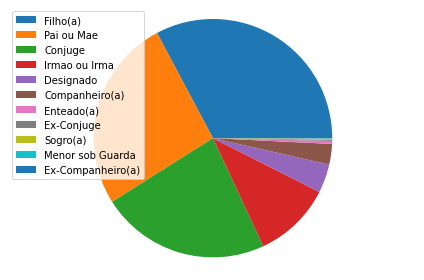

In [42]:
# Gráfico da distribuição de Parentesco
plt.pie(dependentes.Parentesco.value_counts());
plt.legend(labels=dependentes['Parentesco'].value_counts().index.tolist());
plt.axis('equal');
plt.tight_layout();

###### Criando tabela Dependentes com colunas Dummy

In [43]:
# Dados de Parentesco = Filho(a)
dependentes_Filhx = dependentes[dependentes.Parentesco == 'Filho(a)']

lista = [1]*len(dependentes_Filhx)

dependentes_Filhx['Filhx'] = lista

dependentes_Filhx = dependentes_Filhx [['ID', 'Filhx','Parentesco']]

# Criando coluna Filhx 
dependentes_Dummies_Filhx = pd.merge(dependentes,dependentes_Filhx, how='left', on=['ID','Parentesco'])

dependentes_Dummies_Filhx["Filhx"].fillna(value=0, inplace=True)

dependentes_Dummies_Filhx.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ID,Parentesco,DtNascimento,Filhx
0,1,Pai ou Mae,1945-07-26,0.0
1,1,Companheiro(a),1980-08-28,0.0
2,2,Conjuge,1975-07-03,0.0
3,2,Filho(a),2009-07-03,1.0
4,4,Pai ou Mae,1927-11-07,0.0


In [44]:
# Dados de Parentesco = Pai ou Mae
dependentes_PaiMae = dependentes[dependentes.Parentesco == 'Pai ou Mae']

lista = [1]*len(dependentes_PaiMae)

dependentes_PaiMae['PaiMae'] = lista

dependentes_PaiMae = dependentes_PaiMae [['ID', 'PaiMae','Parentesco']]

# Criando coluna PaiMae 
dependentes_Dummies_PaiMae = pd.merge(dependentes_Dummies_Filhx,dependentes_PaiMae, how='left', on=['ID','Parentesco'])

dependentes_Dummies_PaiMae["PaiMae"].fillna(value=0, inplace=True)

dependentes_Dummies_PaiMae.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ID,Parentesco,DtNascimento,Filhx,PaiMae
0,1,Pai ou Mae,1945-07-26,0.0,1.0
1,1,Companheiro(a),1980-08-28,0.0,0.0
2,2,Conjuge,1975-07-03,0.0,0.0
3,2,Filho(a),2009-07-03,1.0,0.0
4,4,Pai ou Mae,1927-11-07,0.0,1.0


In [45]:
# Dados de Parentesco = Conjuge
dependentes_Conjuge = dependentes[dependentes.Parentesco == 'Conjuge']

lista = [1]*len(dependentes_Conjuge)

dependentes_Conjuge['Conjuge'] = lista

dependentes_Conjuge = dependentes_Conjuge [['ID', 'Conjuge','Parentesco']]

# Criando coluna Conjuge 
dependentes_Dummies_Conjuge = pd.merge(dependentes_Dummies_PaiMae,dependentes_Conjuge, how='left', on=['ID','Parentesco'])

dependentes_Dummies_Conjuge["Conjuge"].fillna(value=0, inplace=True)

dependentes_Dummies_Conjuge.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ID,Parentesco,DtNascimento,Filhx,PaiMae,Conjuge
0,1,Pai ou Mae,1945-07-26,0.0,1.0,0.0
1,1,Companheiro(a),1980-08-28,0.0,0.0,0.0
2,2,Conjuge,1975-07-03,0.0,0.0,1.0
3,2,Filho(a),2009-07-03,1.0,0.0,0.0
4,4,Pai ou Mae,1927-11-07,0.0,1.0,0.0


In [46]:
# Dados de Parentesco = Irmx
dependentes_Irmx = dependentes[dependentes.Parentesco == 'Irmx']

lista = [1]*len(dependentes_Irmx)

dependentes_Irmx['Irmx'] = lista

dependentes_Irmx = dependentes_Irmx [['ID', 'Irmx','Parentesco']]

# Criando coluna Irmx 
dependentes_Dummies_Irmx = pd.merge(dependentes_Dummies_Conjuge,dependentes_Irmx, how='left', on=['ID','Parentesco'])

dependentes_Dummies_Irmx["Irmx"].fillna(value=0, inplace=True)

dependentes_Dummies_Irmx.head()

,ID,Parentesco,DtNascimento,Filhx,PaiMae,Conjuge,Irmx
0,1,Pai ou Mae,1945-07-26,0.0,1.0,0.0,0.0
1,1,Companheiro(a),1980-08-28,0.0,0.0,0.0,0.0
2,2,Conjuge,1975-07-03,0.0,0.0,1.0,0.0
3,2,Filho(a),2009-07-03,1.0,0.0,0.0,0.0
4,4,Pai ou Mae,1927-11-07,0.0,1.0,0.0,0.0


In [47]:
# Dados de Parentesco = Designado
dependentes_Designado = dependentes[dependentes.Parentesco == 'Designado']

lista = [1]*len(dependentes_Designado)

dependentes_Designado['Designado'] = lista

dependentes_Designado = dependentes_Designado [['ID', 'Designado','Parentesco']]

# Criando coluna Designado 
dependentes_Dummies_Designado = pd.merge(dependentes_Dummies_Irmx,dependentes_Designado, how='left', on=['ID','Parentesco'])

dependentes_Dummies_Designado["Designado"].fillna(value=0, inplace=True)

dependentes_Dummies_Designado.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ID,Parentesco,DtNascimento,Filhx,PaiMae,Conjuge,Irmx,Designado
0,1,Pai ou Mae,1945-07-26,0.0,1.0,0.0,0.0,0.0
1,1,Companheiro(a),1980-08-28,0.0,0.0,0.0,0.0,0.0
2,2,Conjuge,1975-07-03,0.0,0.0,1.0,0.0,0.0
3,2,Filho(a),2009-07-03,1.0,0.0,0.0,0.0,0.0
4,4,Pai ou Mae,1927-11-07,0.0,1.0,0.0,0.0,0.0


In [48]:
# Dados de Parentesco = Companheiro(a)
dependentes_Companheirx = dependentes[dependentes.Parentesco == 'Companheiro(a)']

lista = [1]*len(dependentes_Companheirx)

dependentes_Companheirx['Companheirx'] = lista

dependentes_Companheirx = dependentes_Companheirx [['ID', 'Companheirx','Parentesco']]

# Criando coluna Companheirx 
dependentes_Dummies_Companheirx = pd.merge(dependentes_Dummies_Designado,dependentes_Companheirx, how='left', on=['ID','Parentesco'])

dependentes_Dummies_Companheirx["Companheirx"].fillna(value=0, inplace=True)

dependentes_Dummies_Companheirx.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ID,Parentesco,DtNascimento,Filhx,PaiMae,Conjuge,Irmx,Designado,Companheirx
0,1,Pai ou Mae,1945-07-26,0.0,1.0,0.0,0.0,0.0,0.0
1,1,Companheiro(a),1980-08-28,0.0,0.0,0.0,0.0,0.0,1.0
2,2,Conjuge,1975-07-03,0.0,0.0,1.0,0.0,0.0,0.0
3,2,Filho(a),2009-07-03,1.0,0.0,0.0,0.0,0.0,0.0
4,4,Pai ou Mae,1927-11-07,0.0,1.0,0.0,0.0,0.0,0.0


In [49]:
# Dados de Parentesco = Enteado(a)
dependentes_Enteadx = dependentes[dependentes.Parentesco == 'Enteado(a)']

lista = [1]*len(dependentes_Enteadx)

dependentes_Enteadx['Enteadx'] = lista

dependentes_Enteadx = dependentes_Enteadx [['ID', 'Enteadx','Parentesco']]

# Criando coluna Enteadx 
dependentes_Dummies_Enteadx = pd.merge(dependentes_Dummies_Companheirx,dependentes_Enteadx, how='left', on=['ID','Parentesco'])

dependentes_Dummies_Enteadx["Enteadx"].fillna(value=0, inplace=True)

dependentes_Dummies_Enteadx.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ID,Parentesco,DtNascimento,Filhx,PaiMae,Conjuge,Irmx,Designado,Companheirx,Enteadx
0,1,Pai ou Mae,1945-07-26,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1,Companheiro(a),1980-08-28,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2,Conjuge,1975-07-03,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,2,Filho(a),2009-07-03,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,Pai ou Mae,1927-11-07,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [50]:
# Dados de Parentesco = Ex-Conjuge
dependentes_ExConj = dependentes[dependentes.Parentesco == 'Ex-Conjuge']

lista = [1]*len(dependentes_ExConj)

dependentes_ExConj['ExConjuge'] = lista

dependentes_ExConj = dependentes_ExConj [['ID', 'ExConjuge','Parentesco']]

# Criando coluna ExConjuge 
dependentes_Dummies_ExConj = pd.merge(dependentes_Dummies_Enteadx,dependentes_ExConj, how='left', on=['ID','Parentesco'])

dependentes_Dummies_ExConj["ExConjuge"].fillna(value=0, inplace=True)

dependentes_Dummies_ExConj.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ID,Parentesco,DtNascimento,Filhx,PaiMae,Conjuge,Irmx,Designado,Companheirx,Enteadx,ExConjuge
0,1,Pai ou Mae,1945-07-26,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,Companheiro(a),1980-08-28,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2,Conjuge,1975-07-03,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2,Filho(a),2009-07-03,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,Pai ou Mae,1927-11-07,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
# Dados de Parentesco = Sogro(a)
dependentes_Sogrx = dependentes[dependentes.Parentesco == 'Sogro(a)']

lista = [1]*len(dependentes_Sogrx)

dependentes_Sogrx['Sogrx'] = lista

dependentes_Sogrx = dependentes_Sogrx [['ID', 'Sogrx','Parentesco']]

# Criando coluna Sogrx 
dependentes_Dummies_Sogrx = pd.merge(dependentes_Dummies_ExConj,dependentes_Sogrx, how='left', on=['ID','Parentesco'])

dependentes_Dummies_Sogrx["Sogrx"].fillna(value=0, inplace=True)

dependentes_Dummies_Sogrx.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ID,Parentesco,DtNascimento,Filhx,PaiMae,Conjuge,Irmx,Designado,Companheirx,Enteadx,ExConjuge,Sogrx
0,1,Pai ou Mae,1945-07-26,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,Companheiro(a),1980-08-28,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2,Conjuge,1975-07-03,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,Filho(a),2009-07-03,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,Pai ou Mae,1927-11-07,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
# Dados de Parentesco = Menor sob Guarda
dependentes_MenorSobGuarda = dependentes[dependentes.Parentesco == 'Menor sob Guarda']

lista = [1]*len(dependentes_MenorSobGuarda)

dependentes_MenorSobGuarda['MenorSobGuarda'] = lista

dependentes_MenorSobGuarda = dependentes_MenorSobGuarda [['ID', 'MenorSobGuarda','Parentesco']]

# Criando coluna MenorSobGuarda 
dependentes_Dummies_MenorSobGuarda = pd.merge(dependentes_Dummies_Sogrx,dependentes_MenorSobGuarda, how='left', on=['ID','Parentesco'])

dependentes_Dummies_MenorSobGuarda["MenorSobGuarda"].fillna(value=0, inplace=True)

dependentes_Dummies_MenorSobGuarda.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ID,Parentesco,DtNascimento,Filhx,PaiMae,Conjuge,Irmx,Designado,Companheirx,Enteadx,ExConjuge,Sogrx,MenorSobGuarda
0,1,Pai ou Mae,1945-07-26,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,Companheiro(a),1980-08-28,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2,Conjuge,1975-07-03,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,Filho(a),2009-07-03,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,Pai ou Mae,1927-11-07,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
# Dados de Parentesco = Ex-Companheiro(a)
dependentes_ExComp = dependentes[dependentes.Parentesco == 'Ex-Companheiro(a)']

lista = [1]*len(dependentes_ExComp)

dependentes_ExComp['ExCompanheirx'] = lista

dependentes_ExComp = dependentes_ExComp [['ID', 'ExCompanheirx','Parentesco']]

# Criando coluna ExCompanheirx 
dependentes_Dummies_ExComp = pd.merge(dependentes_Dummies_MenorSobGuarda,dependentes_ExComp, how='left', on=['ID','Parentesco'])

dependentes_Dummies_ExComp["ExCompanheirx"].fillna(value=0, inplace=True)

dependentes_Dummies_ExComp.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,ID,Parentesco,DtNascimento,Filhx,PaiMae,Conjuge,Irmx,Designado,Companheirx,Enteadx,ExConjuge,Sogrx,MenorSobGuarda,ExCompanheirx
0,1,Pai ou Mae,1945-07-26,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,Companheiro(a),1980-08-28,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2,Conjuge,1975-07-03,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,Filho(a),2009-07-03,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,Pai ou Mae,1927-11-07,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
dependentes_Dummies = dependentes_Dummies_ExComp.drop(columns=['Parentesco'])
dependentes_Dummies.head()

,ID,DtNascimento,Filhx,PaiMae,Conjuge,Irmx,Designado,Companheirx,Enteadx,ExConjuge,Sogrx,MenorSobGuarda,ExCompanheirx
0,1,1945-07-26,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1980-08-28,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2,1975-07-03,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,2009-07-03,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,1927-11-07,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
print(dependentes_Dummies.isnull().any())

ID                False
DtNascimento      False
Filhx             False
PaiMae            False
Conjuge           False
Irmx              False
Designado         False
Companheirx       False
Enteadx           False
ExConjuge         False
Sogrx             False
MenorSobGuarda    False
ExCompanheirx     False
dtype: bool


#### Histórico de Contribuição dos Participantes

In [56]:
# Importando o arquivo historico contibuicao
historicoctb = pd.read_csv('historico ctb.csv', delimiter= ";", engine='python',decimal=',')

# Converte o formato das colunas DtNascimento para datetime
historicoctb['DtVigencia']= pd.to_datetime(historicoctb['DtVigencia'],dayfirst= True)

# Visualização dos dados
historicoctb.head()

,ID,DtVigencia,CtbBasica,CtbAdicional
0,1,2012-05-16,4.0,0.0
1,2,2012-02-03,8.0,0.0
2,3,2011-04-12,5.0,0.0
3,4,1999-01-01,8.0,0.0
4,4,2004-01-01,8.0,4.0


In [57]:
# Criando coluna com a soma das Contribuições (CtbBasica + CtbAdicional)
sum_column = historicoctb["CtbBasica"] + historicoctb["CtbAdicional"]
historicoctb["Contribuicao"] = sum_column
historicoctb.head()

,ID,DtVigencia,CtbBasica,CtbAdicional,Contribuicao
0,1,2012-05-16,4.0,0.0,4.0
1,2,2012-02-03,8.0,0.0,8.0
2,3,2011-04-12,5.0,0.0,5.0
3,4,1999-01-01,8.0,0.0,8.0
4,4,2004-01-01,8.0,4.0,12.0


###### Tratamento dos Dados

In [58]:
# Existem valores nulos (por coluna)? 
print(historicoctb.isnull().any())

ID              False
DtVigencia      False
CtbBasica       False
CtbAdicional    False
Contribuicao    False
dtype: bool


In [59]:
len(historicoctb)

11505

In [60]:
# Limpando inconsistências

# 1. % Ctb. Basica = 0 e % Ctb. Adicional = 0 -> se participante parou de contribuir, não tem relevância para o estudo
historicoctb = historicoctb[historicoctb.Contribuicao != 0]

# 2. Contribuição > 8% -> pelo Regulamento do Plano, o máximo que já foi permitido, foi de 8% de Contribuição Básica
historicoctb = historicoctb[historicoctb.CtbBasica <= 8.0]

#ID 4 apresentou 54% de contribuição adicional em 21/05/2012

In [61]:
 # Checando quantos dados restam
len(historicoctb)

11415

In [62]:
# Visualizando informações mais relevantes
contribuicao = historicoctb [['ID', 'DtVigencia', 'Contribuicao']] 
contribuicao.head()

,ID,DtVigencia,Contribuicao
0,1,2012-05-16,4.0
1,2,2012-02-03,8.0
2,3,2011-04-12,5.0
3,4,1999-01-01,8.0
4,4,2004-01-01,12.0


In [63]:
# Analisando a distribuição das Contribuições dos Participantes
contribuicao.Contribuicao.value_counts(normalize=True)

8.0     0.303285
4.0     0.189750
3.0     0.100832
12.0    0.095313
5.0     0.095050
6.0     0.053176
10.0    0.044503
7.0     0.041524
2.0     0.017784
1.0     0.014192
9.0     0.008060
15.0    0.005869
16.0    0.005344
14.0    0.005081
20.0    0.004906
11.0    0.004818
13.0    0.003329
18.0    0.001752
17.0    0.001139
30.0    0.000701
25.0    0.000613
22.0    0.000438
23.0    0.000438
26.0    0.000350
32.0    0.000175
24.0    0.000175
19.0    0.000175
34.0    0.000175
35.0    0.000175
33.0    0.000175
62.0    0.000088
45.0    0.000088
21.0    0.000088
52.0    0.000088
29.0    0.000088
50.0    0.000088
28.0    0.000088
55.0    0.000088
Name: Contribuicao, dtype: float64

In [64]:
# Analisando a distribuição dos dados de Contribuição
contribuicao['Contribuicao'].describe()

count    11415.000000
mean         6.899956
std          3.568717
min          1.000000
25%          4.000000
50%          7.000000
75%          8.000000
max         62.000000
Name: Contribuicao, dtype: float64

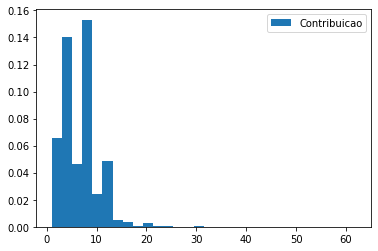

In [65]:
# Gráfico de Distribuição das Contribuições
plt.hist(contribuicao['Contribuicao'], bins=30, label='Contribuicao', density=True)
plt.legend();

#### Histórico do Perfil dos Participantes

In [66]:
# Importando o arquivo historico perfil
historicoprfl = pd.read_csv('historico perfil.csv', delimiter= ";", engine='python', decimal=',', encoding='latin-1')

# convert the 'Date' column to datetime format
historicoprfl['DtVigencia']= pd.to_datetime(historicoprfl['DtVigencia'],dayfirst= True )

# Visualização dos dados
historicoprfl.head()

,ID,DtVigencia,TipoPerfil,Alocacao
0,1,2012-05-16,Renda Fixa,60.0
1,1,2012-05-16,Renda Variavel,40.0
2,1,2012-11-01,Renda Fixa,60.0
3,1,2012-11-01,Renda Variavel,40.0
4,1,2013-11-01,Renda Fixa,60.0


In [67]:
# Agrupando casos em que um mesmo TipoPerfil aparece para mesmo ID e DtVigencia
grupoperfil = historicoprfl.groupby(["ID","DtVigencia","TipoPerfil"])
grupoperfil = grupoperfil.sum()
grupoperfil.head()

Alocacao
ID DtVigencia TipoPerfil              
1  2012-05-16 Renda Fixa          60.0
              Renda Variavel      40.0
   2012-11-01 Renda Fixa          60.0
              Renda Variavel      40.0
   2013-11-01 Renda Fixa          60.0

In [205]:
# Reorganizando a tabela
grupoperfil = grupoperfil.reset_index()
grupoperfil.head()

,index,ID,DtVigencia,TipoPerfil,Alocacao
0,0,1,2012-05-16,Renda Fixa,60.0
1,1,1,2012-05-16,Renda Variavel,40.0
2,2,1,2012-11-01,Renda Fixa,60.0
3,3,1,2012-11-01,Renda Variavel,40.0
4,4,1,2013-11-01,Renda Fixa,60.0


###### Tratamento dos Dados

In [69]:
# Existem valores nulos (por coluna)? 
print(grupoperfil.isnull().any())

ID            False
DtVigencia    False
TipoPerfil    False
Alocacao      False
dtype: bool


In [70]:
# Criando uma nova tabela (perfil) com colunas de RendaFixa e RendaVariavel 
rendafixa = grupoperfil.loc[grupoperfil['TipoPerfil'] == 'Renda Fixa']
rendafixa = rendafixa.drop(columns=['TipoPerfil'])
rendafixa = rendafixa.rename(columns={"Alocacao":"RendaFixa"}) 
rendavariavel = grupoperfil.loc[grupoperfil['TipoPerfil'] == 'Renda Variavel']
rendavariavel = rendavariavel.drop(columns=['TipoPerfil'])
perfil = pd.merge(rendafixa, rendavariavel, how='left', on=['ID','DtVigencia'])
perfil = perfil.rename(columns={"Alocacao":"RendaVariavel"}) 
perfil.head()

,ID,DtVigencia,RendaFixa,RendaVariavel
0,1,2012-05-16,60.0,40.0
1,1,2012-11-01,60.0,40.0
2,1,2013-11-01,60.0,40.0
3,1,2014-11-01,60.0,40.0
4,1,2015-07-01,60.0,40.0


In [71]:
# Conferindo dimensão da tabela rendafixa
len(rendafixa)

65340

In [72]:
# Conferindo dimensão da tabela rendavariavel
len(rendavariavel)

40735

In [73]:
# Conferindo dimensão da tabela perfil -- tem que ser igual a rendafixa
len(perfil)

65340

In [74]:
# tem dados nulos?
print(perfil.isnull().any())

ID               False
DtVigencia       False
RendaFixa        False
RendaVariavel     True
dtype: bool


In [75]:
# Preenchendo dados nulos com 0, pois Alocação Total (Renda Fixa + Renda Variável) = 100%
perfil['RendaVariavel'] = perfil['RendaVariavel'].fillna(0)
print(perfil.isnull().any())

ID               False
DtVigencia       False
RendaFixa        False
RendaVariavel    False
dtype: bool


In [76]:
# Criando coluna com a soma das Alocações (RendaFixa + RendaVariavel) para checar se total = 100%
sum_alocacao = perfil["RendaFixa"] + perfil["RendaVariavel"]
perfil["AlocacaoTotal"]  = sum_alocacao
perfil.head()

,ID,DtVigencia,RendaFixa,RendaVariavel,AlocacaoTotal
0,1,2012-05-16,60.0,40.0,100.0
1,1,2012-11-01,60.0,40.0,100.0
2,1,2013-11-01,60.0,40.0,100.0
3,1,2014-11-01,60.0,40.0,100.0
4,1,2015-07-01,60.0,40.0,100.0


In [77]:
# Existe AlocacaoTotal <> 100% ?
inconsistencia_perfil = perfil[perfil.AlocacaoTotal != 100]
inconsistencia_perfil

,ID,DtVigencia,RendaFixa,RendaVariavel,AlocacaoTotal


In [78]:
# Selecionando colunas relevantes e ordenando por DtVigencia para analisar alterações de alocação ao longo do tempo
perfil = perfil [['ID', 'DtVigencia', 'RendaFixa', 'RendaVariavel']]
perfil.sort_values(by="DtVigencia")
perfil.head() 

,ID,DtVigencia,RendaFixa,RendaVariavel
0,1,2012-05-16,60.0,40.0
1,1,2012-11-01,60.0,40.0
2,1,2013-11-01,60.0,40.0
3,1,2014-11-01,60.0,40.0
4,1,2015-07-01,60.0,40.0


###### Análise dos Dados

In [79]:
# Analisando Alterações de Alocação

# Alteração de Alocação em Renda Fixa
perfil["DiffAlocacao"]  = perfil.RendaFixa.diff()

# Alteração de ID
perfil["DiffID"] = perfil.ID.diff()

# Alteração de Data
perfil["DiffData"] = perfil.DtVigencia.diff()

# Quando não tem com o que comparar, preenche com n/a, então substitui na por 0
perfil['DiffAlocacao'] = perfil['DiffAlocacao'].fillna(0)
perfil['DiffID'] = perfil['DiffID'].fillna(0)
perfil["DiffData"] = perfil["DiffData"].fillna(timedelta(days=0))

# Visualizando a nova tabela perfil
perfil.head()

,ID,DtVigencia,RendaFixa,RendaVariavel,DiffAlocacao,DiffID,DiffData
0,1,2012-05-16,60.0,40.0,0.0,0.0,0 days
1,1,2012-11-01,60.0,40.0,0.0,0.0,169 days
2,1,2013-11-01,60.0,40.0,0.0,0.0,365 days
3,1,2014-11-01,60.0,40.0,0.0,0.0,365 days
4,1,2015-07-01,60.0,40.0,0.0,0.0,242 days


In [80]:
len(perfil)

65340

In [81]:
# Criando tabela com as alocação na DtVigencia mais recente
ultimoperfil = perfil[perfil.DtVigencia == max(perfil.DtVigencia)]
ultimoperfil.head()

,ID,DtVigencia,RendaFixa,RendaVariavel,DiffAlocacao,DiffID,DiffData
10,1,2020-11-03,60.0,40.0,0.0,0.0,368 days
21,2,2020-11-03,80.0,20.0,0.0,0.0,368 days
32,3,2020-11-03,80.0,20.0,0.0,0.0,368 days
53,4,2020-11-03,95.0,5.0,0.0,0.0,368 days
71,5,2020-11-03,100.0,0.0,0.0,0.0,368 days


###Analisando o perfil dos participantes que têm Renda Variavel

In [82]:
# Montando tabela de IDs com alocação mais recente em Renda Variável --> ver perfil de participante que tem Renda Variável hoje
alocRV = ultimoperfil[perfil.RendaVariavel > 0]
alocRV = alocRV.drop(columns=['RendaFixa','DiffAlocacao','DiffData','DiffID'])
alocRV.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,ID,DtVigencia,RendaVariavel
10,1,2020-11-03,40.0
21,2,2020-11-03,20.0
32,3,2020-11-03,20.0
53,4,2020-11-03,5.0
93,6,2020-11-03,10.0


In [83]:
# Quantidade de dados nessa tabela
len(alocRV)

3737

####Analisando as características dos participantes que têm Renda Variavel

In [84]:
# Criando uma nova tabela com todos os ID's dos que têm alocação em Renda Variável, juntando com a tabela grupo
grupo_alocRV = pd.merge(alocRV, grupo, how='left', on=['ID'])
grupo_alocRV = grupo_alocRV.drop(columns=['RendaVariavel','DtVigencia'])
grupo_alocRV.head()

,ID,DtNascimento,Sexo,Escolaridade,FaixaSalarial,DtIncricaoPlano
0,1,1976-01-30,M,Superior Completo,L2,2012-05-16
1,2,1978-10-30,M,Superior Completo,L1,2012-02-03
2,3,1975-11-13,F,Superior Completo,L1,2011-04-12
3,4,1955-06-02,M,Superior Completo,L1,1984-06-25
4,6,1956-04-03,M,Superior Completo,L1,1976-05-24


In [85]:
# Analisando se existe um grupo de participantes específico que aloca em Renda Variável
grupo_alocRV.DtNascimento.describe(datetime_is_numeric=True)
# Observa-se que mais da metade dos participantes estão atualmente alocados em Renda Variável (3737 de 6044), sendo um grupo bem diverso

count                             3737
mean     1977-06-30 08:32:06.679153792
min                1948-12-29 00:00:00
25%                1971-07-06 00:00:00
50%                1978-10-30 00:00:00
75%                1984-03-05 00:00:00
max                2001-02-02 00:00:00
Name: DtNascimento, dtype: object

In [86]:
# Considerando que o grupo é bem variado, não há uma expectativa sobre a Data de Inscrição no Plano
grupo_alocRV.DtIncricaoPlano.describe(datetime_is_numeric=True)

count                             3737
mean     2010-06-28 15:08:14.193206016
min                1975-08-01 00:00:00
25%                2005-11-22 00:00:00
50%                2014-01-24 00:00:00
75%                2018-11-06 00:00:00
max                2020-09-30 00:00:00
Name: DtIncricaoPlano, dtype: object

In [87]:
# Analisando a distribuição de Escolaridade neste grupo
grupo_alocRV['Escolaridade'].value_counts(normalize=True)

Superior Completo      0.628579
2o. Grau Completo      0.222638
Pos-Graduacao          0.096334
Superior Incompleto    0.037463
Mestrado               0.006957
2o. Grau Incompleto    0.006690
1o. Grau Completo      0.001338
Name: Escolaridade, dtype: float64

In [88]:
# Analisando a distribuição de Escolaridade no grupo total
grupo['Escolaridade'].value_counts(normalize=True)

Superior Completo      0.635341
2o. Grau Completo      0.217075
Pos-Graduacao          0.095963
Superior Incompleto    0.036400
Mestrado               0.007280
2o. Grau Incompleto    0.006618
1o. Grau Completo      0.001324
Name: Escolaridade, dtype: float64

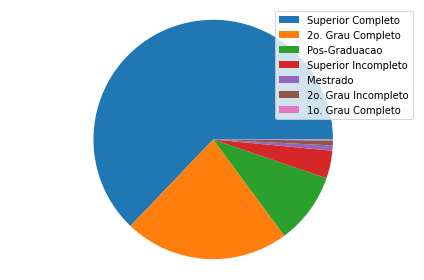

In [89]:
# Gráfico de Distribuição de Escolaridade 
# Observa-se que a proporção de "Superior Completo" é pouco menor nesse grupo do que no grupo total 
# e que a proporção de "2º Grau Completo" é pouco maior
plt.pie(grupo_alocRV.Escolaridade.value_counts());
plt.legend(labels=grupo_alocRV['Escolaridade'].value_counts().index.tolist());
plt.axis('equal');
plt.tight_layout();

In [90]:
# Analisando a distribuição de Sexo neste grupo
grupo_alocRV['Sexo'].value_counts(normalize=True)

M    0.759433
F    0.240567
Name: Sexo, dtype: float64

In [91]:
# Analisando a distribuição de Sexo no grupo total
grupo['Sexo'].value_counts(normalize=True)

M    0.731635
F    0.268365
Name: Sexo, dtype: float64

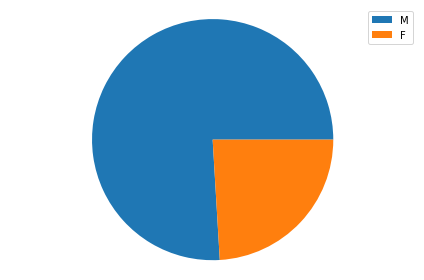

In [92]:
# Gráfico de Distribuição de Sexo
# Observa-se que a proporção de homens nesse grupo é pouco maior do que no grupo total
plt.pie(grupo_alocRV.Sexo.value_counts());
plt.legend(labels=grupo_alocRV['Sexo'].value_counts().index.tolist());
plt.axis('equal');
plt.tight_layout();

In [93]:
# Analisando a Distribuição de Faixa Salarial neste grupo
grupo_alocRV['FaixaSalarial'].value_counts(normalize=True)

L2    0.697083
L3    0.220498
L1    0.082419
Name: FaixaSalarial, dtype: float64

In [94]:
# Analisando a Distribuição de Faixa Salarial no grupo total
grupo['FaixaSalarial'].value_counts(normalize=True)

L2    0.704831
L3    0.212111
L1    0.083058
Name: FaixaSalarial, dtype: float64

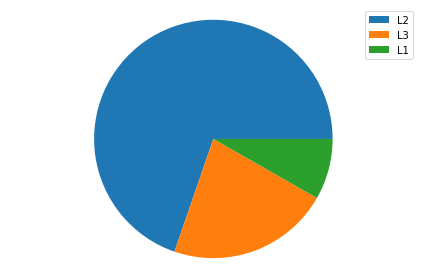

In [95]:
# Gráfico de Distribuição de Faixa Salarial 
# Observa-se que a proporção de L2 é pouco menor neste grupo do que no grupo total e de L3 é pouco maior
plt.pie(grupo_alocRV.FaixaSalarial.value_counts());
plt.legend(labels=grupo_alocRV['FaixaSalarial'].value_counts().index.tolist());
plt.axis('equal');
plt.tight_layout();

####Analisando as características dos dependentes dos participantes que têm Renda Variavel

In [96]:
# Criando uma nova tabela com todos os ID's dos que têm alocações em Renda Variável, juntando com a tabela dependentes
dependentes_alocRV = pd.merge(alocRV, dependentes, how='left', on=['ID'])
dependentes_alocRV = dependentes_alocRV.drop(columns=['RendaVariavel','DtVigencia'])
dependentes_alocRV.head()

,ID,Parentesco,DtNascimento
0,1,Pai ou Mae,1945-07-26
1,1,Companheiro(a),1980-08-28
2,2,Conjuge,1975-07-03
3,2,Filho(a),2009-07-03
4,3,NaN,NaT


In [97]:
# Excluindo valores nulos
dependentes_alocRV_clean=dependentes_alocRV.dropna()
print(dependentes_alocRV_clean.isnull().any())

ID              False
Parentesco      False
DtNascimento    False
dtype: bool


In [98]:
# Verificando se existe um grupo de dependentes em comum entre os participantes
# Analisando as datas de nascimento dos dependentes
dependentes_alocRV = dependentes_alocRV_clean
dependentes_alocRV.DtNascimento.describe(datetime_is_numeric=True)
# Observa-se que é um grupo bem diverso

count                             9687
mean     1979-06-21 18:21:39.969031104
min                1900-01-01 00:00:00
25%                1961-04-05 00:00:00
50%                1980-09-29 00:00:00
75%                1998-04-01 12:00:00
max                2020-11-01 00:00:00
Name: DtNascimento, dtype: object

In [99]:
# Analisando a distribuição de Parentesco neste grupo
dependentes_alocRV['Parentesco'].value_counts(normalize=True)

Filho(a)             0.327139
Pai ou Mae           0.265614
Conjuge              0.231135
Irmao ou Irma        0.105296
Designado            0.036750
Companheiro(a)       0.026530
Enteado(a)           0.004129
Ex-Conjuge           0.001548
Sogro(a)             0.001032
Ex-Companheiro(a)    0.000516
Menor sob Guarda     0.000310
Name: Parentesco, dtype: float64

In [100]:
# Analisando a distribuição de Parentesco no grupo total
dependentes['Parentesco'].value_counts(normalize=True)

Filho(a)             0.327802
Pai ou Mae           0.261811
Conjuge              0.229639
Irmao ou Irma        0.106143
Designado            0.039139
Companheiro(a)       0.027739
Enteado(a)           0.004053
Ex-Conjuge           0.001520
Sogro(a)             0.001330
Menor sob Guarda     0.000443
Ex-Companheiro(a)    0.000380
Name: Parentesco, dtype: float64

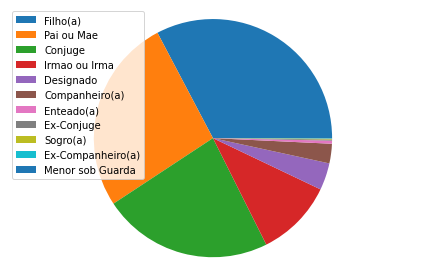

In [101]:
# Gráfico de Distribuição de Parentesco 
# Observa-se que a distribuição é bem similar a do grupo total
plt.pie(dependentes_alocRV.Parentesco.value_counts());
plt.legend(labels=dependentes_alocRV['Parentesco'].value_counts().index.tolist());
plt.axis('equal');
plt.tight_layout();

####Analisando as características das Contribuições dos participantes que têm Renda Variavel

In [102]:
# Criando tabela com IDs e  maior DtVigencia da Contribuicao
# Agrupando dados com mesmo ID
IDcontribuicao = contribuicao.groupby(["ID"])
ultimacontribuicao = IDcontribuicao['DtVigencia'].max()
ultimacontribuicao = ultimacontribuicao.reset_index()
ultimacontribuicao.head(10)

,ID,DtVigencia
0,1,2012-05-16
1,2,2012-02-03
2,3,2011-04-12
3,4,2012-05-21
4,5,2006-03-07
5,6,2010-01-01
6,7,1999-01-01
7,8,2015-05-01
8,9,2012-01-01
9,10,1999-01-01


In [103]:
# Inserindo a coluna Contribuicao de volta na tabela
contribuicao_ult = pd.merge(ultimacontribuicao, contribuicao, how='left', on=['ID','DtVigencia'])

In [104]:
print(contribuicao_ult.isnull().any())

ID              False
DtVigencia      False
Contribuicao    False
dtype: bool


In [105]:
print(alocRV.isnull().any())

ID               False
DtVigencia       False
RendaVariavel    False
dtype: bool


In [106]:
# Criando uma nova tabela com todos os ID's dos que têm alocações em Renda Variável, juntando com a tabela dependentes
contribuicao_alocRV = pd.merge(alocRV, contribuicao_ult, how='inner', on=['ID'])
contribuicao_alocRV = contribuicao_alocRV.drop(columns=['RendaVariavel','DtVigencia_y'])
contribuicao_alocRV = contribuicao_alocRV.rename(columns={"DtVigencia_x": "DtVigencia"})
contribuicao_alocRV.head()

,ID,DtVigencia,Contribuicao
0,1,2020-11-03,4.0
1,2,2020-11-03,8.0
2,3,2020-11-03,5.0
3,4,2020-11-03,62.0
4,6,2020-11-03,15.0


In [107]:
print(contribuicao_alocRV.isnull().any())

ID              False
DtVigencia      False
Contribuicao    False
dtype: bool


In [108]:
# Verificando se é um grupo de participantes com uma característica específica de contribuições
contribuicao_alocRV.Contribuicao.describe()
# Observa-se que é um grupo bem diverso e similar ao grupo total

count    3720.000000
mean        6.734140
std         3.314235
min         1.000000
25%         4.000000
50%         7.000000
75%         8.000000
max        62.000000
Name: Contribuicao, dtype: float64

In [109]:
# Verificando a moda desta distribuição
contribuicao_alocRV.Contribuicao.mode()

0    8.0
dtype: float64

In [110]:
# Verificando a distribuição da Contribuição do grupo total
contribuicao.Contribuicao.describe()

count    11415.000000
mean         6.899956
std          3.568717
min          1.000000
25%          4.000000
50%          7.000000
75%          8.000000
max         62.000000
Name: Contribuicao, dtype: float64

In [111]:
# Verificando a moda desta distribuição
contribuicao.Contribuicao.mode()

0    8.0
dtype: float64

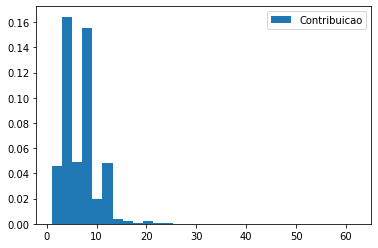

In [112]:
# Gráfico de Distribuição das Contribuições
plt.hist(contribuicao_alocRV['Contribuicao'], bins=30, label='Contribuicao', density=True)
plt.legend();
# Observa-se um comportamento muito próximo ao do grupo total

###Analisando o perfil dos 25% dos participantes que mais têm Renda Variável

In [113]:
# Na tabela perfil, observa-se que 25% dos participantes têm entre 30% e 60% de alocação em Renda Variável
ultimoperfil.RendaVariavel.describe()

count    6042.000000
mean       18.587223
std        21.075119
min         0.000000
25%         0.000000
50%        10.000000
75%        30.000000
max        60.000000
Name: RendaVariavel, dtype: float64

In [114]:
# Montando tabela de IDs com alocação de pelo menos 30% em Renda Variável
maioresRV = ultimoperfil[ultimoperfil.RendaVariavel >= 30]
maioresRV = maioresRV.drop(columns=['RendaFixa','DiffAlocacao','DiffData','DiffID'])
maioresRV.head()

,ID,DtVigencia,RendaVariavel
10,1,2020-11-03,40.0
784,41,2020-11-03,50.0
927,54,2020-11-03,60.0
1552,88,2020-11-03,30.0
1598,92,2020-11-03,50.0


####Analisando as características dos participantes que mais têm Renda Variável

In [115]:
# Criando uma nova tabela com todos os ID's e características dos que têm maiores alocações em Renda Variável
grupo_maioresRV = pd.merge(maioresRV, grupo, how='left', on=['ID'])
grupo_maioresRV.head()

,ID,DtVigencia,RendaVariavel,DtNascimento,Sexo,Escolaridade,FaixaSalarial,DtIncricaoPlano
0,1,2020-11-03,40.0,1976-01-30,M,Superior Completo,L2,2012-05-16
1,41,2020-11-03,50.0,1980-09-15,F,2o. Grau Completo,L1,2017-04-18
2,54,2020-11-03,60.0,1980-03-05,F,Superior Completo,L1,2019-03-14
3,88,2020-11-03,30.0,1976-11-23,M,2o. Grau Completo,L2,2019-05-31
4,92,2020-11-03,50.0,1985-12-06,M,Superior Completo,L2,2019-01-02


In [116]:
# É esperado que a idade máxima seja <55 anos,
# pois existe uma regra do plano que participantes elegíveis (maiores de 55 anos) só podem alocar até 20% em RV
grupo_maioresRV.DtNascimento.describe(datetime_is_numeric=True)

count                             1774
mean     1981-10-06 09:58:14.475761024
min                1970-11-07 00:00:00
25%                1977-08-04 06:00:00
50%                1981-06-15 12:00:00
75%                1986-01-05 06:00:00
max                2001-02-02 00:00:00
Name: DtNascimento, dtype: object

In [117]:
# Considerando que a idade máxima é 50 anos, espera-se que as Datas de Inscrição sejam no mínimo 1990
grupo_maioresRV.DtIncricaoPlano.describe(datetime_is_numeric=True)

count                             1774
mean     2014-07-23 18:22:19.346110208
min                1993-11-24 00:00:00
25%                2011-03-30 06:00:00
50%                2016-11-24 00:00:00
75%                2019-03-27 18:00:00
max                2020-09-30 00:00:00
Name: DtIncricaoPlano, dtype: object

In [118]:
# Analisando a distribuição de Escolaridade neste grupo
grupo_maioresRV['Escolaridade'].value_counts(normalize=True)

Superior Completo      0.605411
2o. Grau Completo      0.250282
Pos-Graduacao          0.080045
Superior Incompleto    0.049042
2o. Grau Incompleto    0.008455
Mestrado               0.006201
1o. Grau Completo      0.000564
Name: Escolaridade, dtype: float64

In [119]:
# Analisando a distribuição de Escolaridade no grupo total
grupo['Escolaridade'].value_counts(normalize=True)

Superior Completo      0.635341
2o. Grau Completo      0.217075
Pos-Graduacao          0.095963
Superior Incompleto    0.036400
Mestrado               0.007280
2o. Grau Incompleto    0.006618
1o. Grau Completo      0.001324
Name: Escolaridade, dtype: float64

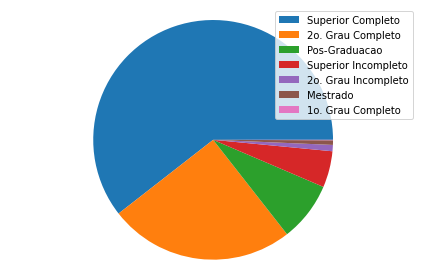

In [120]:
# Gráfico de Distribuição de Escolaridade 
# Observa-se que a proporção de "Superior Completo" é menor nesse grupo do que no grupo total e que a proporção de "2º Grau Completo" é maior
plt.pie(grupo_maioresRV.Escolaridade.value_counts());
plt.legend(labels=grupo_maioresRV['Escolaridade'].value_counts().index.tolist());
plt.axis('equal');
plt.tight_layout();

In [121]:
# Analisando a distribuição de Sexo neste grupo
grupo_maioresRV['Sexo'].value_counts(normalize=True)

M    0.782413
F    0.217587
Name: Sexo, dtype: float64

In [122]:
# Analisando a distribuição de Sexo no grupo total
grupo['Sexo'].value_counts(normalize=True)

M    0.731635
F    0.268365
Name: Sexo, dtype: float64

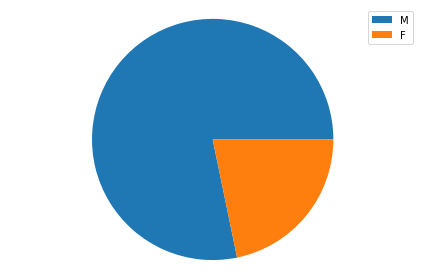

In [123]:
# Gráfico de Distribuição de Sexo
# Observa-se que a proporção de homens nesse grupo é maior do que no grupo total
plt.pie(grupo_maioresRV.Sexo.value_counts());
plt.legend(labels=grupo_maioresRV['Sexo'].value_counts().index.tolist());
plt.axis('equal');
plt.tight_layout();

In [124]:
# Analisando a Distribuição de Faixa Salarial neste grupo
grupo_maioresRV['FaixaSalarial'].value_counts(normalize=True)

L2    0.749718
L3    0.153326
L1    0.096956
Name: FaixaSalarial, dtype: float64

In [125]:
# Analisando a Distribuição de Faixa Salarial no grupo total
grupo['FaixaSalarial'].value_counts(normalize=True)

L2    0.704831
L3    0.212111
L1    0.083058
Name: FaixaSalarial, dtype: float64

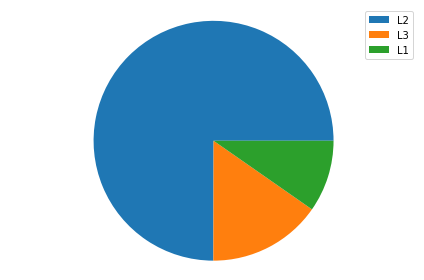

In [126]:
# Gráfico Distribuição de Faixa Salarial de Faixa Salarial
# Observa-se que a proporção de L2 é maior neste grupo do que no grupo total e de L3 é menor
plt.pie(grupo_maioresRV.FaixaSalarial.value_counts());
plt.legend(labels=grupo_maioresRV['FaixaSalarial'].value_counts().index.tolist());
plt.axis('equal');
plt.tight_layout();

####Analisando as características dos dependentes destes participantes

In [127]:
# Criando uma nova tabela com todos os ID's e dependentes dos participantes que têm maiores alocações em Renda Variável
dependentes_maioresRV = pd.merge(maioresRV, dependentes, how='left', on=['ID'])
dependentes_maioresRV = dependentes_maioresRV.drop(columns=['RendaVariavel','DtVigencia'])
dependentes_maioresRV.head()

,ID,Parentesco,DtNascimento
0,1,Pai ou Mae,1945-07-26
1,1,Companheiro(a),1980-08-28
2,41,Conjuge,1974-12-11
3,41,Filho(a),2007-06-04
4,54,Filho(a),2002-10-17


In [128]:
# Excluindo valores nulos
dependentes_maioresRV_clean=dependentes_maioresRV.dropna()
print(dependentes_maioresRV_clean.isnull().any())

ID              False
Parentesco      False
DtNascimento    False
dtype: bool


In [129]:
# Verificando se existe um grupo de dependentes em comum entre os participantes
dependentes_maioresRV = dependentes_maioresRV_clean
dependentes_maioresRV.DtNascimento.describe(datetime_is_numeric=True)
# Observa-se que é um grupo bem diverso

count                             4290
mean     1981-08-14 19:45:54.125874752
min                1900-01-01 00:00:00
25%                1961-02-25 06:00:00
50%                1981-10-23 00:00:00
75%                2002-10-01 12:00:00
max                2020-11-01 00:00:00
Name: DtNascimento, dtype: object

In [130]:
# Analisando a distribuição de Parentesco neste grupo
dependentes_maioresRV['Parentesco'].value_counts(normalize=True)

Pai ou Mae           0.302098
Filho(a)             0.282984
Conjuge              0.236364
Irmao ou Irma        0.114219
Designado            0.036131
Companheiro(a)       0.019580
Enteado(a)           0.004196
Ex-Conjuge           0.001865
Sogro(a)             0.001399
Menor sob Guarda     0.000699
Ex-Companheiro(a)    0.000466
Name: Parentesco, dtype: float64

In [131]:
# Analisando a distribuição de Parentesco no grupo total
dependentes['Parentesco'].value_counts(normalize=True)

Filho(a)             0.327802
Pai ou Mae           0.261811
Conjuge              0.229639
Irmao ou Irma        0.106143
Designado            0.039139
Companheiro(a)       0.027739
Enteado(a)           0.004053
Ex-Conjuge           0.001520
Sogro(a)             0.001330
Menor sob Guarda     0.000443
Ex-Companheiro(a)    0.000380
Name: Parentesco, dtype: float64

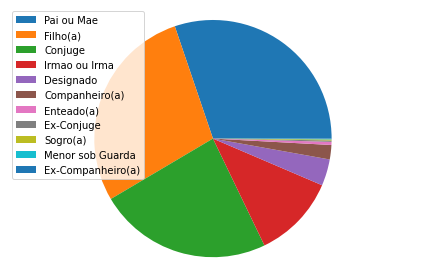

In [132]:
# Gráfico de Distribuição de Parentesco 
# Observa-se que a proporção de Filho(a) é menor neste grupo do que no grupo total, e a proporção de Pai ou Mae é maior
plt.pie(dependentes_maioresRV.Parentesco.value_counts());
plt.legend(labels=dependentes_maioresRV['Parentesco'].value_counts().index.tolist());
plt.axis('equal');
plt.tight_layout();

####Analisando as contribuições destes participantes

In [133]:
# Criando uma nova tabela com todos os ID's com as contribuições dos participantes que têm maiores alocações em Renda Variável
contribuicao_maioresRV = pd.merge(maioresRV, contribuicao_ult, how='inner', on=['ID'])
contribuicao_maioresRV = contribuicao_maioresRV.drop(columns=['RendaVariavel','DtVigencia_y'])
contribuicao_maioresRV = contribuicao_maioresRV.rename(columns={"DtVigencia_x": "DtVigencia"})
contribuicao_maioresRV.head()

,ID,DtVigencia,Contribuicao
0,1,2020-11-03,4.0
1,41,2020-11-03,4.0
2,54,2020-11-03,4.0
3,88,2020-11-03,4.0
4,92,2020-11-03,4.0


In [134]:
# Verificando se é um grupo de participantes com uma característica específica de contribuições
contribuicao_maioresRV.Contribuicao.describe()
# Observa-se que é um grupo bem diverso, porém diferente do grupo total, já que apresenta menores contribuições

count    1769.000000
mean        5.984737
std         2.776211
min         1.000000
25%         4.000000
50%         5.000000
75%         8.000000
max        20.000000
Name: Contribuicao, dtype: float64

In [135]:
# Verificando a moda desta distribuição
contribuicao_maioresRV.Contribuicao.mode()

0    4.0
dtype: float64

In [136]:
# Verificando a distribuição do grupo total
contribuicao.Contribuicao.describe()

count    11415.000000
mean         6.899956
std          3.568717
min          1.000000
25%          4.000000
50%          7.000000
75%          8.000000
max         62.000000
Name: Contribuicao, dtype: float64

In [137]:
# Verificando a moda desta distribuição
contribuicao.Contribuicao.mode()

0    8.0
dtype: float64

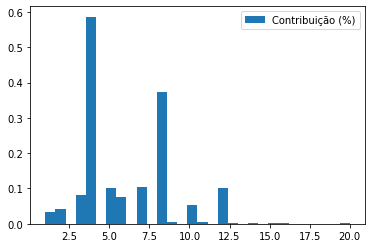

In [138]:
# Gráfico de Distribuição das Contribuições
plt.hist(contribuicao_maioresRV['Contribuicao'], bins=30, label='Contribuição (%)', density=True)
plt.legend();
# Observa-se que a média, o desvio padrão e a moda são menores do que o grupo total, com um máximo de contribuição = 20%

###Analisando o perfil dos participantes que têm Renda Fixa (todos)

In [139]:
# Montando tabela de IDs com alocação mais recente em Renda Fixa
# São todos os participantes, porque a alocação máxima permitida em RV é 60%
alocRF = ultimoperfil[ultimoperfil.RendaFixa > 0]
alocRF = alocRF.drop(columns=['RendaVariavel','DiffAlocacao','DiffData','DiffID'])
alocRF.head()

,ID,DtVigencia,RendaFixa
10,1,2020-11-03,60.0
21,2,2020-11-03,80.0
32,3,2020-11-03,80.0
53,4,2020-11-03,95.0
71,5,2020-11-03,100.0


####Analisando as características dos participantes que têm Renda Fixa

In [140]:
# Criando uma nova tabela com todos os ID's e características dos participantes que têm alocação em Renda Fixa
grupo_alocRF = pd.merge(alocRF, grupo, how='left', on=['ID'])
grupo_alocRF.head()

,ID,DtVigencia,RendaFixa,DtNascimento,Sexo,Escolaridade,FaixaSalarial,DtIncricaoPlano
0,1,2020-11-03,60.0,1976-01-30,M,Superior Completo,L2,2012-05-16
1,2,2020-11-03,80.0,1978-10-30,M,Superior Completo,L1,2012-02-03
2,3,2020-11-03,80.0,1975-11-13,F,Superior Completo,L1,2011-04-12
3,4,2020-11-03,95.0,1955-06-02,M,Superior Completo,L1,1984-06-25
4,5,2020-11-03,100.0,1971-03-17,F,Superior Completo,L1,2006-03-07


In [141]:
len(grupo)

6044

In [142]:
# Observou-se que não há dados de alocação para os IDs 42 e 1111, por isso há 6042 dados nesta tabela
len(grupo_alocRF)
# Como é o grupo total, não foi feita a análise deste grupo

6042

####Analisando as características dos dependentes dos participantes que têm Renda Fixa

In [143]:
# Criando uma nova tabela com todos os ID's e os dependentes dos participantes que têm alocação em Renda Fixa
dependentes_alocRF = pd.merge(alocRF, dependentes, how='left', on=['ID'])
dependentes_alocRF = dependentes_alocRF.drop(columns=['RendaFixa','DtVigencia'])
dependentes_alocRF.head()

,ID,Parentesco,DtNascimento
0,1,Pai ou Mae,1945-07-26
1,1,Companheiro(a),1980-08-28
2,2,Conjuge,1975-07-03
3,2,Filho(a),2009-07-03
4,3,NaN,NaT


In [144]:
# Excluindo valores nulos
dependentes_alocRF_clean=dependentes_alocRF.dropna()
print(dependentes_alocRF_clean.isnull().any())

ID              False
Parentesco      False
DtNascimento    False
dtype: bool


In [145]:
# Verificando se existe um grupo de dependentes em comum entre os participantes
dependentes_alocRF = dependentes_alocRF_clean
dependentes_alocRF.DtNascimento.describe(datetime_is_numeric=True)
# Observa-se que é um grupo bem diverso e próximo ao grupo total

count                            15784
mean     1979-02-19 05:31:48.565636288
min                1900-01-01 00:00:00
25%                1960-11-27 12:00:00
50%                1980-07-01 00:00:00
75%                1997-10-16 00:00:00
max                2020-11-01 00:00:00
Name: DtNascimento, dtype: object

In [146]:
# Analisando a distribuição de Parentesco neste grupo
dependentes_alocRF['Parentesco'].value_counts(normalize=True)

Filho(a)             0.327674
Pai ou Mae           0.261911
Conjuge              0.229600
Irmao ou Irma        0.106183
Designado            0.039154
Companheiro(a)       0.027750
Enteado(a)           0.004055
Ex-Conjuge           0.001521
Sogro(a)             0.001330
Menor sob Guarda     0.000443
Ex-Companheiro(a)    0.000380
Name: Parentesco, dtype: float64

In [147]:
# Analisando a distribuição de Parentesco no grupo total
dependentes['Parentesco'].value_counts(normalize=True)

Filho(a)             0.327802
Pai ou Mae           0.261811
Conjuge              0.229639
Irmao ou Irma        0.106143
Designado            0.039139
Companheiro(a)       0.027739
Enteado(a)           0.004053
Ex-Conjuge           0.001520
Sogro(a)             0.001330
Menor sob Guarda     0.000443
Ex-Companheiro(a)    0.000380
Name: Parentesco, dtype: float64

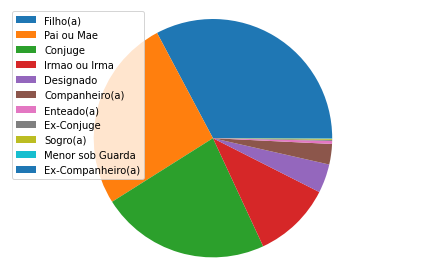

In [148]:
# Gráfico de Distribuição de Parentesco 
# Observa-se que a distribuição é bem similar a do grupo total
plt.pie(dependentes_alocRF.Parentesco.value_counts());
plt.legend(labels=dependentes_alocRF['Parentesco'].value_counts().index.tolist());
plt.axis('equal');
plt.tight_layout();

####Analisando as contribuições destes participantes

In [149]:
# Criando uma nova tabela com todos os ID's dos que têm alocações em Renda Fixa, juntando com a tabela contribuicao
contribuicao_alocRF = pd.merge(alocRF, contribuicao_ult, how='inner', on=['ID'])
contribuicao_alocRF = contribuicao_alocRF.drop(columns=['RendaFixa','DtVigencia_y'])
contribuicao_alocRF = contribuicao_alocRF.rename(columns={"DtVigencia_x": "DtVigencia"})
contribuicao_alocRF.head()

,ID,DtVigencia,Contribuicao
0,1,2020-11-03,4.0
1,2,2020-11-03,8.0
2,3,2020-11-03,5.0
3,4,2020-11-03,62.0
4,5,2020-11-03,8.0


In [150]:
# Verificando se é um grupo de participantes com uma característica específica de contribuições
contribuicao_alocRF.Contribuicao.describe()
# Observa-se que é um grupo bem diverso e similar ao grupo total

count    6021.000000
mean        6.731108
std         3.291327
min         1.000000
25%         4.000000
50%         7.000000
75%         8.000000
max        62.000000
Name: Contribuicao, dtype: float64

In [151]:
# Verificando a moda desta distribuição
contribuicao_alocRF.Contribuicao.mode()

0    8.0
dtype: float64

In [152]:
 # Verificando a distribuição do grupo total
contribuicao.Contribuicao.describe()

count    11415.000000
mean         6.899956
std          3.568717
min          1.000000
25%          4.000000
50%          7.000000
75%          8.000000
max         62.000000
Name: Contribuicao, dtype: float64

In [153]:
# Verificando a moda
contribuicao.Contribuicao.mode()

0    8.0
dtype: float64

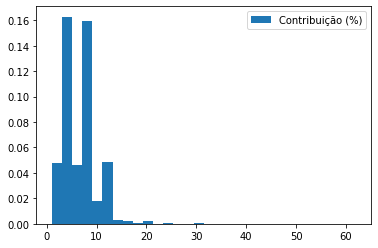

In [154]:
# Gráfico de Distribuição das Contribuições
plt.hist(contribuicao_alocRF['Contribuicao'], bins=30, label='Contribuição (%)', density=True)
plt.legend();
# Observa-se que como se trata da maioria do grupo total, a distribuição é bem similar

###Analisando o perfil dos participantes que têm pelo menos 70% em Renda Fixa

In [155]:
# Montando tabela de IDs com alocação mais recente de pelo menos 70% em Renda Fixa 
antimaioresRV_RF = ultimoperfil[ultimoperfil.RendaFixa >= 70]
antimaioresRV_RF = antimaioresRV_RF.drop(columns=['RendaVariavel','DiffAlocacao','DiffData','DiffID'])
antimaioresRV_RF.head()

,ID,DtVigencia,RendaFixa
21,2,2020-11-03,80.0
32,3,2020-11-03,80.0
53,4,2020-11-03,95.0
71,5,2020-11-03,100.0
93,6,2020-11-03,90.0


####Analisando as características dos participantes que têm pelo menos 70% em Renda Fixa

In [156]:
# Criando uma nova tabela com todos os ID's dos que têm alocações de pelo menos 70% em Renda Fixa 
grupo_antimaioresRV_RF = pd.merge(antimaioresRV_RF, grupo, how='left', on=['ID'])
grupo_antimaioresRV_RF.head()

,ID,DtVigencia,RendaFixa,DtNascimento,Sexo,Escolaridade,FaixaSalarial,DtIncricaoPlano
0,2,2020-11-03,80.0,1978-10-30,M,Superior Completo,L1,2012-02-03
1,3,2020-11-03,80.0,1975-11-13,F,Superior Completo,L1,2011-04-12
2,4,2020-11-03,95.0,1955-06-02,M,Superior Completo,L1,1984-06-25
3,5,2020-11-03,100.0,1971-03-17,F,Superior Completo,L1,2006-03-07
4,6,2020-11-03,90.0,1956-04-03,M,Superior Completo,L1,1976-05-24


In [157]:
# É esperado o oposto do que foi visto no grupo maioresRV
grupo_antimaioresRV_RF.DtNascimento.describe(datetime_is_numeric=True)

count                             4669
mean     1975-06-07 03:09:22.090383232
min                1948-05-13 00:00:00
25%                1967-11-20 00:00:00
50%                1976-09-06 00:00:00
75%                1982-09-20 00:00:00
max                1998-07-07 00:00:00
Name: DtNascimento, dtype: object

In [158]:
# Como a Data de Nascimento deste grupo é bastante diversa, não se espera um padrão na Data de Inscrição
grupo_antimaioresRV_RF.DtIncricaoPlano.describe(datetime_is_numeric=True)

count                             4669
mean     2008-08-04 20:47:32.859280128
min                1975-08-01 00:00:00
25%                2003-02-20 00:00:00
50%                2012-03-09 00:00:00
75%                2017-07-24 00:00:00
max                2020-09-29 00:00:00
Name: DtIncricaoPlano, dtype: object

In [159]:
# Analisando a distribuição de Escolaridade neste grupo
grupo_antimaioresRV_RF['Escolaridade'].value_counts(normalize=True)

Superior Completo      0.645320
2o. Grau Completo      0.204326
Pos-Graduacao          0.102592
Superior Incompleto    0.032769
Mestrado               0.007496
2o. Grau Incompleto    0.005997
1o. Grau Completo      0.001499
Name: Escolaridade, dtype: float64

In [160]:
# Analisando a distribuição de Escolaridade no grupo total
grupo['Escolaridade'].value_counts(normalize=True)

Superior Completo      0.635341
2o. Grau Completo      0.217075
Pos-Graduacao          0.095963
Superior Incompleto    0.036400
Mestrado               0.007280
2o. Grau Incompleto    0.006618
1o. Grau Completo      0.001324
Name: Escolaridade, dtype: float64

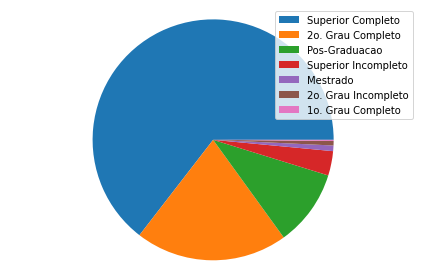

In [161]:
# Gráfico de Distribuição de Escolaridade 
# Observa-se que a proporção de "Superior Completo" é pouco maior nesse grupo do que no grupo total 
# e que a proporção de "2º Grau Completo" é pouco menor
plt.pie(grupo_antimaioresRV_RF.Escolaridade.value_counts());
plt.legend(labels=grupo_antimaioresRV_RF['Escolaridade'].value_counts().index.tolist());
plt.axis('equal');
plt.tight_layout();

In [162]:
# Analisando a distribuição de Sexo neste grupo
grupo_antimaioresRV_RF['Sexo'].value_counts(normalize=True)

M    0.713001
F    0.286999
Name: Sexo, dtype: float64

In [163]:
# Analisando a distribuição de Sexo no grupo total
grupo['Sexo'].value_counts(normalize=True)

M    0.731635
F    0.268365
Name: Sexo, dtype: float64

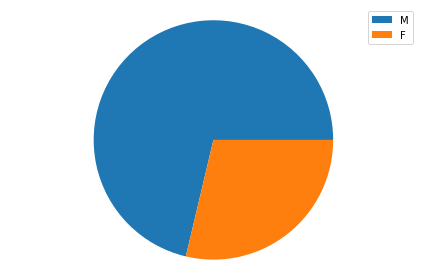

In [164]:
# Gráfico de Distribuição de Sexo
# Observa-se que a proporção de mulheres nesse grupo é maior do que no grupo total
plt.pie(grupo_antimaioresRV_RF.Sexo.value_counts());
plt.legend(labels=grupo_antimaioresRV_RF['Sexo'].value_counts().index.tolist());
plt.axis('equal');
plt.tight_layout();

In [165]:
# Analisando a Distribuição de Faixa Salarial neste grupo
grupo_antimaioresRV_RF['FaixaSalarial'].value_counts(normalize=True)

L2    0.687942
L3    0.234740
L1    0.077318
Name: FaixaSalarial, dtype: float64

In [166]:
# Analisando a Distribuição de Faixa Salarial no grupo total
grupo['FaixaSalarial'].value_counts(normalize=True)

L2    0.704831
L3    0.212111
L1    0.083058
Name: FaixaSalarial, dtype: float64

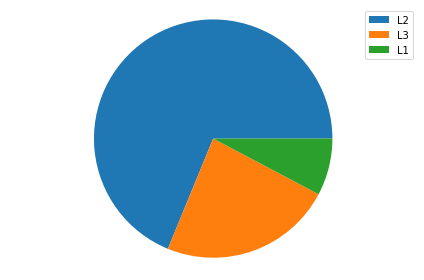

In [167]:
# Gráfico Distribuição de Faixa Salarial de Faixa Salarial
# Observa-se que a proporção de L2 é pouco menor neste grupo do que no grupo total e de L3 é pouco maior
plt.pie(grupo_antimaioresRV_RF.FaixaSalarial.value_counts());
plt.legend(labels=grupo_antimaioresRV_RF['FaixaSalarial'].value_counts().index.tolist());
plt.axis('equal');
plt.tight_layout();

####Analisando as características dos dependentes destes participantes que têm pelo menos 70% em Renda Fixa

In [168]:
# Criando uma nova tabela com todos os ID's dos que têm 70% de alocação em Renda Fixa, juntando com a tabela dependentes
dependentes_antimaioresRV_RF = pd.merge(antimaioresRV_RF, dependentes, how='left', on=['ID'])
dependentes_antimaioresRV_RF = dependentes_antimaioresRV_RF.drop(columns=['RendaFixa','DtVigencia'])
dependentes_antimaioresRV_RF.head()

,ID,Parentesco,DtNascimento
0,2,Conjuge,1975-07-03
1,2,Filho(a),2009-07-03
2,3,NaN,NaT
3,4,Pai ou Mae,1927-11-07
4,4,Pai ou Mae,1929-05-04


In [169]:
# Excluindo valores nulos
dependentes_antimaioresRV_RF_clean=dependentes_antimaioresRV_RF.dropna()
print(dependentes_antimaioresRV_RF_clean.isnull().any())

ID              False
Parentesco      False
DtNascimento    False
dtype: bool


In [170]:
# Verificando se existe um grupo de dependentes em comum entre os participantes
dependentes_antimaioresRV_RF = dependentes_antimaioresRV_RF_clean
dependentes_antimaioresRV_RF.DtNascimento.describe(datetime_is_numeric=True)
# Observa-se que é um grupo bem diverso e próximo ao grupo total

count                            12530
mean     1978-06-02 11:15:10.774141920
min                1900-01-01 00:00:00
25%                1960-11-08 06:00:00
50%                1980-01-28 00:00:00
75%                1996-10-27 18:00:00
max                2020-08-19 00:00:00
Name: DtNascimento, dtype: object

In [171]:
# Analisando a distribuição de Parentesco neste grupo
dependentes_antimaioresRV_RF['Parentesco'].value_counts(normalize=True)

Filho(a)             0.341421
Pai ou Mae           0.249481
Conjuge              0.227614
Irmao ou Irma        0.104150
Designado            0.039665
Companheiro(a)       0.030407
Enteado(a)           0.003990
Sogro(a)             0.001277
Ex-Conjuge           0.001277
Ex-Companheiro(a)    0.000399
Menor sob Guarda     0.000319
Name: Parentesco, dtype: float64

In [172]:
# Analisando a distribuição de Parentesco no grupo total
dependentes['Parentesco'].value_counts(normalize=True)

Filho(a)             0.327802
Pai ou Mae           0.261811
Conjuge              0.229639
Irmao ou Irma        0.106143
Designado            0.039139
Companheiro(a)       0.027739
Enteado(a)           0.004053
Ex-Conjuge           0.001520
Sogro(a)             0.001330
Menor sob Guarda     0.000443
Ex-Companheiro(a)    0.000380
Name: Parentesco, dtype: float64

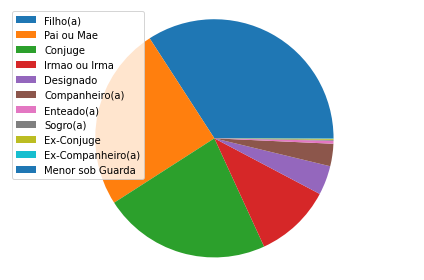

In [173]:
# Gráfico de Distribuição de Parentesco 
# Observa-se que a distribuição é bem similar a do grupo total, sendo a proporção de Filho (a) pouco maior e Pai ou Mae pouco menor
plt.pie(dependentes_antimaioresRV_RF.Parentesco.value_counts());
plt.legend(labels=dependentes_antimaioresRV_RF['Parentesco'].value_counts().index.tolist());
plt.axis('equal');
plt.tight_layout();

####Analisando as contribuições destes participantes que têm pelo menos 70% em Renda Fixa

In [174]:
# Criando uma nova tabela com todos os ID's dos que têm 70% de alocação em Renda Fixa, juntando com a tabela contribuicao
contribuicao_antimaioresRV_RF = pd.merge(antimaioresRV_RF, contribuicao_ult, how='inner', on=['ID'])
contribuicao_antimaioresRV_RF = contribuicao_antimaioresRV_RF.drop(columns=['RendaFixa','DtVigencia_y'])
contribuicao_antimaioresRV_RF = contribuicao_antimaioresRV_RF.rename(columns={"DtVigencia_x": "DtVigencia"})
contribuicao_antimaioresRV_RF.head()

,ID,DtVigencia,Contribuicao
0,2,2020-11-03,8.0
1,3,2020-11-03,5.0
2,4,2020-11-03,62.0
3,5,2020-11-03,8.0
4,6,2020-11-03,15.0


In [175]:
# Verificando se é um grupo de participantes com uma característica específica de contribuições
contribuicao_antimaioresRV_RF.Contribuicao.describe()
# Observa-se que é um grupo bem diverso e similar ao grupo total

count    4653.000000
mean        6.983881
std         3.404191
min         1.000000
25%         4.000000
50%         8.000000
75%         8.000000
max        62.000000
Name: Contribuicao, dtype: float64

In [176]:
contribuicao_antimaioresRV_RF.Contribuicao.mode()

0    8.0
dtype: float64

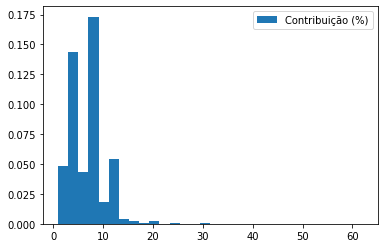

In [177]:
# Gráfico de Distribuição das Contribuições
plt.hist(contribuicao_antimaioresRV_RF['Contribuicao'], bins=30, label='Contribuição (%)', density=True)
plt.legend();
# Observa-se que a distribuição é bem similar ao grupo total

###Analisando o perfil dos 25% dos participantes que mais têm Renda Fixa

In [178]:
# Na tabela perfil, observa-se que 25% dos participantes têm 100% alocado em Renda Fixa
ultimoperfil.RendaFixa.describe()

count    6042.000000
mean       81.412777
std        21.075119
min        40.000000
25%        70.000000
50%        90.000000
75%       100.000000
max       100.000000
Name: RendaFixa, dtype: float64

In [179]:
# Montando tabela de IDs com alocação mais recente de 100% em Renda Fixa 
maioresRF = ultimoperfil[ultimoperfil.RendaFixa == 100]
maioresRF = maioresRF.drop(columns=['RendaVariavel','DiffAlocacao','DiffData','DiffID'])
maioresRF.head()

,ID,DtVigencia,RendaFixa
71,5,2020-11-03,100.0
136,8,2020-11-03,100.0
157,9,2020-11-03,100.0
177,10,2020-11-03,100.0
210,12,2020-11-03,100.0


####Analisando as características dos participantes que mais têm Renda Fixa

In [180]:
# Criando uma nova tabela com todos os ID's dos que têm maiores alocações em Renda Fixa (100% de alocação)
grupo_maioresRF = pd.merge(maioresRF, grupo, how='left', on=['ID'])
grupo_maioresRF.head()

,ID,DtVigencia,RendaFixa,DtNascimento,Sexo,Escolaridade,FaixaSalarial,DtIncricaoPlano
0,5,2020-11-03,100.0,1971-03-17,F,Superior Completo,L1,2006-03-07
1,8,2020-11-03,100.0,1960-08-21,M,Superior Completo,L1,1993-11-24
2,9,2020-11-03,100.0,1958-10-30,F,2o. Grau Completo,L1,1993-11-25
3,10,2020-11-03,100.0,1955-11-25,F,Superior Completo,L1,1984-07-03
4,12,2020-11-03,100.0,1957-02-03,F,Superior Completo,L2,1978-01-09


In [181]:
# É esperado o oposto do que foi visto no grupo maioresRV
grupo_maioresRF.DtNascimento.describe(datetime_is_numeric=True)

count                             2305
mean     1976-04-04 01:43:04.815618208
min                1948-05-13 00:00:00
25%                1969-04-27 00:00:00
50%                1978-01-29 00:00:00
75%                1983-05-27 00:00:00
max                1997-10-16 00:00:00
Name: DtNascimento, dtype: object

In [182]:
# Como a Data  de Nascimento deste grupo é bastante diversa, não se espera um padrão na Data de Inscrição
grupo_maioresRF.DtIncricaoPlano.describe(datetime_is_numeric=True)

count                             2305
mean     2009-05-15 20:23:13.145336832
min                1975-08-20 00:00:00
25%                2005-06-15 00:00:00
50%                2014-01-10 00:00:00
75%                2017-07-24 00:00:00
max                2020-09-25 00:00:00
Name: DtIncricaoPlano, dtype: object

In [183]:
# Analisando a distribuição de Escolaridade neste grupo
grupo_maioresRF['Escolaridade'].value_counts(normalize=True)

Superior Completo      0.646855
2o. Grau Completo      0.207375
Pos-Graduacao          0.095445
Superior Incompleto    0.034707
Mestrado               0.007809
2o. Grau Incompleto    0.006508
1o. Grau Completo      0.001302
Name: Escolaridade, dtype: float64

In [184]:
# Analisando a distribuição de Escolaridade no grupo total
grupo['Escolaridade'].value_counts(normalize=True)

Superior Completo      0.635341
2o. Grau Completo      0.217075
Pos-Graduacao          0.095963
Superior Incompleto    0.036400
Mestrado               0.007280
2o. Grau Incompleto    0.006618
1o. Grau Completo      0.001324
Name: Escolaridade, dtype: float64

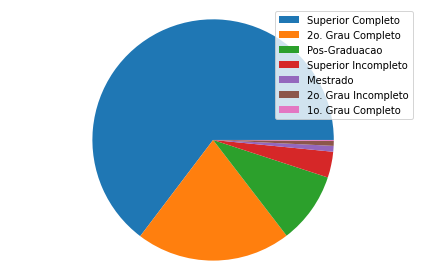

In [185]:
# Gráfico de Distribuição de Escolaridade 
# Observa-se que a proporção de "Superior Completo" é maior nesse grupo do que no grupo total e que a proporção de "2º Grau Completo" é menor
plt.pie(grupo_maioresRF.Escolaridade.value_counts());
plt.legend(labels=grupo_maioresRF['Escolaridade'].value_counts().index.tolist());
plt.axis('equal');
plt.tight_layout();

In [186]:
# Analisando a distribuição de Sexo neste grupo
grupo_maioresRF['Sexo'].value_counts(normalize=True)

M    0.686334
F    0.313666
Name: Sexo, dtype: float64

In [187]:
# Analisando a distribuição de Sexo no grupo total
grupo['Sexo'].value_counts(normalize=True)

M    0.731635
F    0.268365
Name: Sexo, dtype: float64

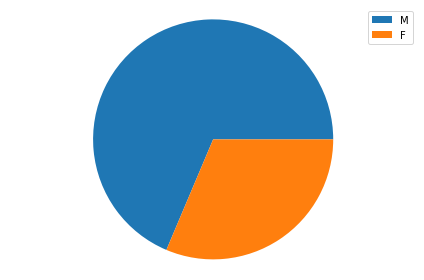

In [188]:
# Gráfico de Distribuição de Sexo
# Observa-se que a proporção de mulheres nesse grupo é maior do que no grupo total
plt.pie(grupo_maioresRF.Sexo.value_counts());
plt.legend(labels=grupo_maioresRF['Sexo'].value_counts().index.tolist());
plt.axis('equal');
plt.tight_layout();

In [189]:
# Analisando a Distribuição de Faixa Salarial neste grupo
grupo_maioresRF['FaixaSalarial'].value_counts(normalize=True)

L2    0.717570
L3    0.198698
L1    0.083731
Name: FaixaSalarial, dtype: float64

In [190]:
# Analisando a Distribuição de Faixa Salarial no grupo total
grupo['FaixaSalarial'].value_counts(normalize=True)

L2    0.704831
L3    0.212111
L1    0.083058
Name: FaixaSalarial, dtype: float64

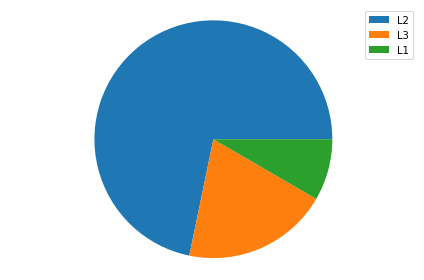

In [191]:
# Gráfico Distribuição de Faixa Salarial de Faixa Salarial
# Observa-se que a proporção de L2 é pouco maior neste grupo do que no grupo total e de L3 é pouco menor
plt.pie(grupo_maioresRF.FaixaSalarial.value_counts());
plt.legend(labels=grupo_maioresRF['FaixaSalarial'].value_counts().index.tolist());
plt.axis('equal');
plt.tight_layout();

####Analisando as características dos dependentes destes participantes que têm 100% em Renda Fixa

In [192]:
# Criando uma nova tabela com todos os ID's dos que têm alocações em Renda Fixa, juntando com a tabela dependentes
dependentes_maioresRF = pd.merge(maioresRF, dependentes, how='left', on=['ID'])
dependentes_maioresRF = dependentes_maioresRF.drop(columns=['RendaFixa','DtVigencia'])
dependentes_maioresRF.head()

,ID,Parentesco,DtNascimento
0,5,Conjuge,1971-04-17
1,5,Filho(a),1998-02-20
2,5,Filho(a),2002-01-14
3,8,Conjuge,1948-10-10
4,8,Enteado(a),1975-10-02


In [193]:
# Verificando se existe um grupo de dependentes em comum entre os participantes
dependentes_maioresRF.DtNascimento.describe(datetime_is_numeric=True)
# Observa-se que é um grupo bem diverso e próximo ao grupo total

count                             6097
mean     1978-08-08 13:05:46.596687296
min                1900-01-12 00:00:00
25%                1960-08-18 00:00:00
50%                1980-02-17 00:00:00
75%                1997-02-01 00:00:00
max                2020-08-19 00:00:00
Name: DtNascimento, dtype: object

In [194]:
# Analisando a distribuição de Parentesco neste grupo
dependentes_maioresRF['Parentesco'].value_counts(normalize=True)

Filho(a)             0.328522
Pai ou Mae           0.256028
Conjuge              0.227161
Irmao ou Irma        0.107594
Designado            0.042972
Companheiro(a)       0.029687
Enteado(a)           0.003936
Sogro(a)             0.001804
Ex-Conjuge           0.001476
Menor sob Guarda     0.000656
Ex-Companheiro(a)    0.000164
Name: Parentesco, dtype: float64

In [195]:
# Analisando a distribuição de Parentesco no grupo total
dependentes['Parentesco'].value_counts(normalize=True)

Filho(a)             0.327802
Pai ou Mae           0.261811
Conjuge              0.229639
Irmao ou Irma        0.106143
Designado            0.039139
Companheiro(a)       0.027739
Enteado(a)           0.004053
Ex-Conjuge           0.001520
Sogro(a)             0.001330
Menor sob Guarda     0.000443
Ex-Companheiro(a)    0.000380
Name: Parentesco, dtype: float64

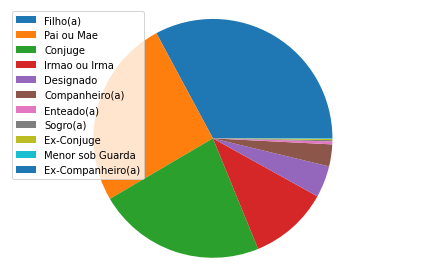

In [196]:
# Gráfico de Distribuição de Parentesco 
# Observa-se que a distribuição é bem similar a do grupo total
plt.pie(dependentes_maioresRF.Parentesco.value_counts());
plt.legend(labels=dependentes_maioresRF['Parentesco'].value_counts().index.tolist());
plt.axis('equal');
plt.tight_layout();

####Analisando as contribuições destes participantes que têm 100% em Renda Fixa

In [197]:
# Criando uma nova tabela com todos os ID's dos que têm alocações em Renda Fixa, juntando com a tabela contribuicao
contribuicao_maioresRF = pd.merge(maioresRF, contribuicao_ult, how='inner', on=['ID'])
contribuicao_maioresRF = contribuicao_maioresRF.drop(columns=['RendaFixa','DtVigencia_y'])
contribuicao_maioresRF = contribuicao_maioresRF.rename(columns={"DtVigencia_x": "DtVigencia"})
contribuicao_maioresRF.head()

,ID,DtVigencia,Contribuicao
0,5,2020-11-03,8.0
1,8,2020-11-03,12.0
2,9,2020-11-03,8.0
3,10,2020-11-03,8.0
4,12,2020-11-03,3.0


In [198]:
# Verificando se é um grupo de participantes com uma característica específica de contribuições
contribuicao_maioresRF.Contribuicao.describe()
# Observa-se que é um grupo bem diverso e similar ao grupo total

count    2301.000000
mean        6.726206
std         3.254663
min         1.000000
25%         4.000000
50%         7.000000
75%         8.000000
max        35.000000
Name: Contribuicao, dtype: float64

In [199]:
contribuicao_maioresRF.Contribuicao.mode()

0    8.0
dtype: float64

In [200]:
contribuicao.Contribuicao.describe()

count    11415.000000
mean         6.899956
std          3.568717
min          1.000000
25%          4.000000
50%          7.000000
75%          8.000000
max         62.000000
Name: Contribuicao, dtype: float64

In [201]:
contribuicao.Contribuicao.mode()

0    8.0
dtype: float64

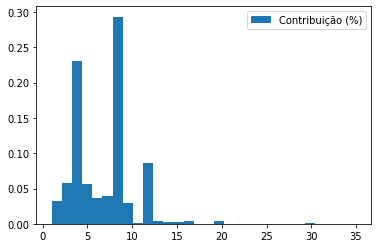

In [214]:
# Gráfico de Distribuição das Contribuições
plt.hist(contribuicao_maioresRF['Contribuicao'], bins=30, label='Contribuição (%)', density=True)
plt.legend();
# Observa-se que a distribuição é bem similar ao grupo total

###Clusterização dos Participantes

In [248]:
grupo_Dummies.head()

,ID,M,F,SuperiorCompleto,SegGrauCompleto,PosGraduacao,SuperiorIncompleto,Mestrado,SegGrauIncompleto,PrimGrauCompleto,L1,L2,L3
0,1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


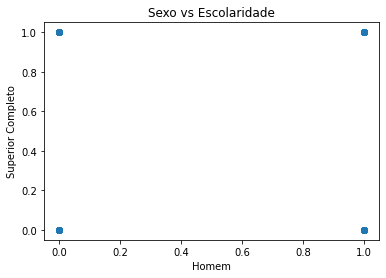

In [215]:
plt.scatter(x=grupo_Dummies['M'], y=grupo_Dummies['SuperiorCompleto'])
plt.title('Sexo vs Escolaridade')
plt.ylabel('Superior Completo')
plt.xlabel('Homem')
plt.show()

In [216]:
#seed
seed = 0
np.random.seed(seed)

In [266]:
kmeans = KMeans(n_clusters=4, random_state=seed)
kmeans = kmeans.fit(grupo_Dummies)

In [267]:
kmeans.labels_

array([2, 2, 2, ..., 1, 1, 1], dtype=int32)

In [268]:
# Centróides: muito importante analisar.
# Eles nos dizem sobre o perfil de cada grupo
kmeans.cluster_centers_

array([[2.27700000e+03, 7.13434811e-01, 2.86565189e-01, 6.32693580e-01,
        2.21707478e-01, 8.40502978e-02, 5.16214428e-02, 4.63269358e-03,
        5.29450695e-03, 2.84060969e-17, 1.05228326e-01, 6.90933157e-01,
        2.03838518e-01],
       [5.29150000e+03, 7.56308101e-01, 2.43691899e-01, 6.26826029e-01,
        2.31739708e-01, 8.76494024e-02, 2.92164675e-02, 9.96015936e-03,
        1.39442231e-02, 6.64010624e-04, 7.37051793e-02, 7.31075697e-01,
        1.95219124e-01],
       [7.61000000e+02, 7.06114398e-01, 2.93885602e-01, 6.06180145e-01,
        2.34714004e-01, 1.21630506e-01, 2.49835634e-02, 5.91715976e-03,
        6.57462196e-03, 2.81892565e-17, 7.75805391e-02, 6.88362919e-01,
        2.34056542e-01],
       [3.78550000e+03, 7.50996016e-01, 2.49003984e-01, 6.75962815e-01,
        1.79946879e-01, 9.03054449e-02, 3.98406375e-02, 8.63213811e-03,
        6.64010624e-04, 4.64807437e-03, 7.56972112e-02, 7.09163347e-01,
        2.15139442e-01]])

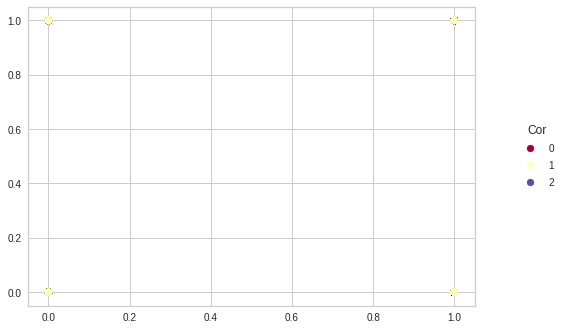

In [260]:
# Gráfico da separação dos grupos formados
fig = plt.scatter(x=grupo_Dummies['M'], y=grupo_Dummies['L1'], c=kmeans.labels_, cmap='Spectral')
handles, labels = fig.legend_elements(prop="colors")
plt.legend(handles, labels, loc='center right', bbox_to_anchor=(1.2, 0.5), title='Cor')
plt.show()

In [261]:
wcss = []
davies_bouldin = []
K = range(2,10)
for k in K:
  kmeans = KMeans(n_clusters=k, random_state=seed)
  kmeans.fit(grupo_Dummies)
  wcss.append(kmeans.inertia_)
  davies_bouldin.append(davies_bouldin_score(grupo_Dummies, kmeans.labels_))

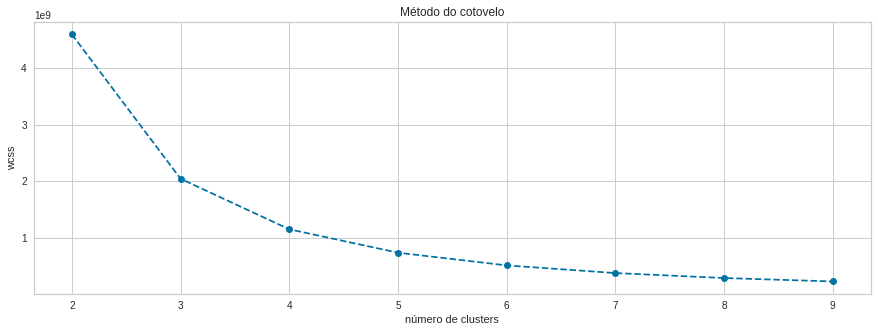

In [262]:
plt.figure(figsize= (15, 5))
plt.plot(K, wcss, 'bo--')
plt.xlabel('número de clusters')
plt.ylabel('wcss')
plt.title('Método do cotovelo')
plt.show()

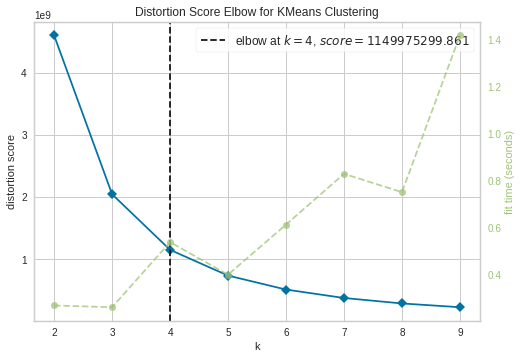

In [265]:
visualizer = KElbowVisualizer(kmeans, k=(2,10))
visualizer.fit(grupo_Dummies) 
visualizer.poof()

In [269]:
unique, counts = np.unique(kmeans.labels_, return_counts=True)
print(dict(zip(unique, counts)))

{0: 1513, 1: 1506, 2: 1518, 3: 1507}


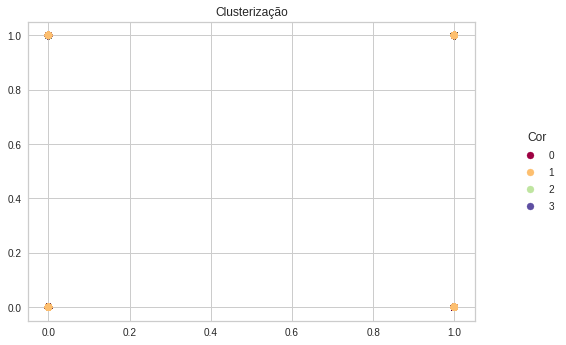

In [270]:
fig = plt.scatter(x=grupo_Dummies['M'], y=grupo_Dummies['L1'], c=kmeans.labels_, cmap='Spectral')

handles, labels = fig.legend_elements(prop="colors")
plt.legend(handles, labels, loc='center right', bbox_to_anchor=(1.2, 0.5), title='Cor')
plt.title('Clusterização')
plt.show()